## Тестовое задание "Прогнозирование дебита жидкости" <a id = 'x'></a>

В задаче предстоит построить модель прогнозирования дебита жидкости (признак Q_OIS) после геолого-технического мероприятия (ГТМ) интенсификации добычи нефти (ИДН).
Прогноз необходимо сделать на дату выхода скажины на режим (ВНР). Выход скважины на режим задается бинарным признаком VNR (при выходе на режим – VNR=1).

Не стоит путать ВНР - выход скажины на режим (признак VNR), с BHP - bottom hole pressure (забойное давление, признак BHP).

Каждому событию ИДН на конкретной скважине предшествует своя история, которую можно получить, отфильтровав данные по идентификатору события ИДН (признак id).
В тренировочном датасете train.csv для каждого события ИДН (признак id) известно значение дебита жидкости Q_OIS на дату ВНР (VNR=1), а в тестовом датасете test.csv , соответственно, нет.

Также в качестве дополнительной информации дан файл well_works.csv со всеми типами ГТМ, проведенными на исследуемых скважинах.
В качестве событий ИДН рассматриваются события со значениями 2 и 7 в столбце GTM_type_lbl.



Dataset Description

contest_train_df.csv - обучающая выборка

test.csv - тестовая выборка

well_works.csv - файл с дополнительной информацией о проведенных геолого-технических мероприятиях (ГТМ)

sample_submission.csv - пример файла с ответами

Columns\
Dnytr - …\
H_din - динамический уровень\
Q_OIS - дебит жидкости\
NomMoschn - номинальная мощность\
Hperf - глубина перфораций\
NomNapor - номинальный напор\
Water_cut - обводненность\
NomPodacha - номинальная подача\
Dnkt - диаметр НКТ\
H_sp - глубина спуска\
P_plst - пластовое давление\
Hvd - глубина верхних дыр перфораций\
Extend_Hvd - удлинение верхних дыр перфораций\
PlNeft - плотность нефти\
VyazkNeft - вязкость нефти\
SumTolshin - сумма нефтенасыщенных толщин\
P_zatr - затрубное давление\
PlVody - плотность воды\
Pnas - давление насыщения\
Inject_0, Inject_1, Inject_2, Inject_3 - приемистость ближайших нагнетательных скважин\
BHP - забойное давление\
IDN_type - тип ГТМ (категориальный признак)\
NalichSep - наличие сепаратора (бинарный признак)\
Formation_lbl - метка пласта (категориальный признак)\
state_age - …\
Date - дата измерения значений вещественных признаков (таких, как Q_OIS и BHP)\
Start_date - дата начала события ГТМ\
Well_ID - идентификатор скважины\
id - идентификатор события ГТМ\
VNR - признак выхода на режим (бинарный признак)\
\
Date_VNR - дата выхода на режим\
GTM_type_lbl - метка типа ГТМ (категориальный признак)\


Решение оценивается с помощью метрики MAPE.


## Содержание <a id = 'intro'></a>

<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-библиотек" data-toc-modified-id="Загрузка-библиотек-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка библиотек</a></span></li><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Изменение-типов-данных" data-toc-modified-id="Изменение-типов-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Изменение типов данных</a></span></li><li><span><a href="#Работа-с-пропусками-и-аномальными-значениями" data-toc-modified-id="Работа-с-пропусками-и-аномальными-значениями-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Работа с пропусками и аномальными значениями</a></span></li><li><span><a href="#Подготовка-признаков" data-toc-modified-id="Подготовка-признаков-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Подготовка признаков</a></span></li><li><span><a href="#Предобработка-тестового-датасета" data-toc-modified-id="Предобработка-тестового-датасета-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Предобработка тестового датасета</a></span></li><li><span><a href="#Базовая-модель" data-toc-modified-id="Базовая-модель-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Базовая модель</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Обучение моделей</a></span></li><li><span><a href="#Анализ-полученных-результатов" data-toc-modified-id="Анализ-полученных-результатов-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Анализ полученных результатов</a></span></li><li><span><a href="#Анализ-важности-признаков" data-toc-modified-id="Анализ-важности-признаков-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Анализ важности признаков</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Вывод</a></span></li>

## Загрузка библиотек 

[Содержание](#intro)

В первую очередь выполним загрузку необходимых библиотек.

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder

from xgboost import plot_importance
from xgboost import XGBRegressor

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

## Загрузка данных

[Описание](#x)

[Содержание](#intro)

В качестве исходных данных представлены 3 файла: вся информация о датах проведения ГТМ, полученных дебитах и различных вещественных признаках дана в **contest_train_df**, тестовый набор данных представлен в **test**, дополнительная информация о проведенных ГТМ дана в **well_works**.

In [2]:
file_1 = 'contest_train_df.csv'
file_2 = 'test.csv'
file_3 = 'well_works.csv'
file_4 = 'sample_submission.csv'

In [3]:
raw_data_train = pd.read_csv(r'C:/Users/aygul/OneDrive/Документы/Башнипи/' + file_1)

In [4]:
raw_data_test = pd.read_csv(r'C:/Users/aygul/OneDrive/Документы/Башнипи/' + file_2)

In [5]:
data_gtm = pd.read_csv(r'C:/Users/aygul/OneDrive/Документы/Башнипи/' + file_3)

In [6]:
sample = pd.read_csv(r'C:/Users/aygul/OneDrive/Документы/Башнипи/' + file_4)

In [7]:
raw_data_train

,Dnytr,H_din,Q_OIS,NomMoschn,Hperf,NomNapor,Water_cut,NomPodacha,Dnkt,H_sp,...,State,IDN_type,NalichSep,Formation_lbl,state_age,Date,Start_date,Well_ID,id,VNR
0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1487.0,...,0,1,NaN,"2,5",30.0,1965-01-16,1965-06-21,4473,30413,0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1320.0,...,1,1,NaN,"24,26",31.0,1965-01-16,1965-03-12,3905,26087,0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2100.0,...,1,1,NaN,38,131.0,1965-01-16,1965-06-29,8467,58863,0
3,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,1,NaN,"45,46",28.0,1965-01-16,1965-05-05,8092,56313,0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2321.0,...,1,1,NaN,"2,5",616.0,1965-01-16,1965-06-21,4136,27819,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2782436,130.6,2120.0,32.0,58.0,17.0,2378.0,7.0,60.0,73.0,2480.0,...,1,0,0.0,35,1.0,1980-01-04,1979-12-25,7984,55726,1
2782437,129.0,2500.0,30.0,40.0,51.0,2190.0,9.0,50.0,73.0,2652.0,...,1,0,1.0,"3,5",625.0,1980-01-04,1979-12-28,6200,42565,1
2782438,130.6,2269.0,64.0,50.0,22.0,2393.0,5.0,50.0,73.0,2791.0,...,1,0,0.0,35,71.0,1980-01-04,1979-12-24,7465,52512,1
2782439,130.6,NaN,396.0,180.0,13.0,2000.0,95.0,200.0,73.0,2260.0,...,1,1,1.0,23,19.0,1980-01-04,1979-12-26,806,4545,1


Изменим регистр названия колонок на "змеиный регистр".

In [8]:
import string

def to_snake_case(value, delimiter='_'):
    value = value[0].lower() + value[1:]
    for x in string.ascii_uppercase:
        value = value.replace(x, delimiter + x.lower())
    return value  

In [9]:
col = list(raw_data_train.columns)

In [10]:
for a in range(len(col)):
    col[a] = to_snake_case(col[a])
    col[a] = col[a].replace('__','_')

In [11]:
raw_data_train.columns = col
raw_data_train.columns

Index(['dnytr', 'h_din', 'q_o_i_s', 'nom_moschn', 'hperf', 'nom_napor',
       'water_cut', 'nom_podacha', 'dnkt', 'h_sp', 'p_plst', 'hvd',
       'extend_hvd', 'pl_neft', 'vyazk_neft', 'sum_tolshin', 'p_zatr',
       'pl_vody', 'pnas', 'inject_0', 'inject_1', 'inject_2', 'inject_3',
       'b_h_p', 'state', 'i_d_n_type', 'nalich_sep', 'formation_lbl',
       'state_age', 'date', 'start_date', 'well_i_d', 'id', 'v_n_r'],
      dtype='object')

In [12]:
raw_data_train = raw_data_train.rename(columns = {'dnytr':'d_nytr','q_o_i_s':'q_ois', 'hperf':'h_perf','dnkt':'d_nkt',\
                                'hvd':'h_vd','pnas':'p_nas', 'b_h_p':'bhp','i_d_n_type':'idn_type',\
                                'well_i_d':'well_id','v_n_r':'vnr'})

In [13]:
raw_data_train

,d_nytr,h_din,q_ois,nom_moschn,h_perf,nom_napor,water_cut,nom_podacha,d_nkt,h_sp,...,state,idn_type,nalich_sep,formation_lbl,state_age,date,start_date,well_id,id,vnr
0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1487.0,...,0,1,NaN,"2,5",30.0,1965-01-16,1965-06-21,4473,30413,0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1320.0,...,1,1,NaN,"24,26",31.0,1965-01-16,1965-03-12,3905,26087,0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2100.0,...,1,1,NaN,38,131.0,1965-01-16,1965-06-29,8467,58863,0
3,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,1,NaN,"45,46",28.0,1965-01-16,1965-05-05,8092,56313,0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2321.0,...,1,1,NaN,"2,5",616.0,1965-01-16,1965-06-21,4136,27819,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2782436,130.6,2120.0,32.0,58.0,17.0,2378.0,7.0,60.0,73.0,2480.0,...,1,0,0.0,35,1.0,1980-01-04,1979-12-25,7984,55726,1
2782437,129.0,2500.0,30.0,40.0,51.0,2190.0,9.0,50.0,73.0,2652.0,...,1,0,1.0,"3,5",625.0,1980-01-04,1979-12-28,6200,42565,1
2782438,130.6,2269.0,64.0,50.0,22.0,2393.0,5.0,50.0,73.0,2791.0,...,1,0,0.0,35,71.0,1980-01-04,1979-12-24,7465,52512,1
2782439,130.6,NaN,396.0,180.0,13.0,2000.0,95.0,200.0,73.0,2260.0,...,1,1,1.0,23,19.0,1980-01-04,1979-12-26,806,4545,1


In [14]:
raw_data_test

,Dnytr,H_din,Q_OIS,NomMoschn,Hperf,NomNapor,Water_cut,NomPodacha,Dnkt,H_sp,...,State,IDN_type,NalichSep,Formation_lbl,state_age,Date,Start_date,Well_ID,id,VNR
0,129.0,NaN,NaN,200.0,26.4,2005.0,NaN,400.0,73.000000,2160.0,...,1,0,1.0,"24,26",548.0,1979-07-06,1979-12-26,3926,26251,0
1,129.0,NaN,NaN,200.0,26.4,2005.0,NaN,400.0,73.000000,2160.0,...,1,0,1.0,"24,26",548.0,1979-07-07,1979-12-26,3926,26251,0
2,129.0,NaN,NaN,140.0,5.2,2206.0,NaN,250.0,73.000000,2360.0,...,1,1,1.0,23,180.0,1979-07-07,1979-12-28,2053,13063,0
3,130.6,NaN,NaN,40.0,40.3,2279.0,NaN,50.0,64.960000,2500.0,...,1,1,1.0,18,247.0,1979-07-07,1979-12-29,2497,16620,0
4,NaN,NaN,67.0,NaN,NaN,NaN,5.0,NaN,NaN,2480.0,...,1,0,NaN,35,17.0,1979-07-08,1979-10-17,7983,55712,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
675072,129.0,NaN,NaN,56.0,14.9,2085.0,93.0,80.0,73.000000,2162.0,...,1,0,0.0,"24,26",490.0,1981-07-04,1981-06-25,3683,24309,1
675073,127.0,1563.0,NaN,NaN,61.0,NaN,93.0,NaN,74.802112,2557.0,...,1,1,0.0,"3,5",215.0,1981-07-04,1981-06-21,5178,35548,1
675074,130.6,NaN,NaN,70.0,8.9,2058.0,94.0,125.0,73.000000,2380.0,...,1,0,1.0,23,337.0,1981-07-04,1981-06-27,2210,14120,1
675075,129.0,1961.0,NaN,80.0,54.0,2396.0,15.0,100.0,73.000000,2420.0,...,1,1,1.0,5,25.0,1981-07-05,1981-06-28,6702,44834,1


In [15]:
raw_data_test.columns = raw_data_train.columns

In [16]:
# raw_data_test

In [17]:
data_gtm.columns = map(str.lower, data_gtm.columns)
# data_gtm

In [18]:
# выводит общую информацию о датасете
def general_info(data):
    display(data.head(10))
    print(data.info())
    print('-' * 100)
    print('\nЯвных дубликатов:', data.duplicated().sum())
    print('\nКоличество пропусков:')
    print(data.isna().sum())
    
#     data.hist(figsize=(15, 15), rwidth=0.9)
#     plt.show()
    
#     display(data.describe())
    
#     fig, ax = plt.subplots(figsize=(20,10))
#     sns.heatmap(data.corr(), annot=True, fmt='.1f', annot_kws={"fontsize": 7}, ax=ax)
#     plt.show()

Выполним чтение исходной информации.

In [19]:
general_info(raw_data_train)

,d_nytr,h_din,q_ois,nom_moschn,h_perf,nom_napor,water_cut,nom_podacha,d_nkt,h_sp,...,state,idn_type,nalich_sep,formation_lbl,state_age,date,start_date,well_id,id,vnr
0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1487.0,...,0,1,NaN,"2,5",30.0,1965-01-16,1965-06-21,4473,30413,0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1320.0,...,1,1,NaN,"24,26",31.0,1965-01-16,1965-03-12,3905,26087,0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2100.0,...,1,1,NaN,38,131.0,1965-01-16,1965-06-29,8467,58863,0
3,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,1,NaN,"45,46",28.0,1965-01-16,1965-05-05,8092,56313,0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2321.0,...,1,1,NaN,"2,5",616.0,1965-01-16,1965-06-21,4136,27819,0
5,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,1,NaN,45,52.0,1965-01-16,1965-06-04,8090,56302,0
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2185.0,...,1,1,NaN,23,169.0,1965-01-16,1965-06-12,769,4377,0
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2085.0,...,1,1,NaN,7,547.0,1965-01-16,1965-07-08,6908,46487,0
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,1,NaN,23,311.0,1965-01-16,1965-03-23,1210,6782,0
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1620.0,...,1,1,NaN,23,374.0,1965-01-16,1965-03-23,1611,9600,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2782441 entries, 0 to 2782440
Data columns (total 34 columns):
 #   Column         Dtype  
---  ------         -----  
 0   d_nytr         float64
 1   h_din          float64
 2   q_ois          float64
 3   nom_moschn     float64
 4   h_perf         float64
 5   nom_napor      float64
 6   water_cut      float64
 7   nom_podacha    float64
 8   d_nkt          float64
 9   h_sp           float64
 10  p_plst         float64
 11  h_vd           float64
 12  extend_hvd     float64
 13  pl_neft        float64
 14  vyazk_neft     float64
 15  sum_tolshin    float64
 16  p_zatr         float64
 17  pl_vody        float64
 18  p_nas          float64
 19  inject_0       float64
 20  inject_1       float64
 21  inject_2       float64
 22  inject_3       float64
 23  bhp            float64
 24  state          int64  
 25  idn_type       int64  
 26  nalich_sep     float64
 27  formation_lbl  object 
 28  state_age      float64
 29  date          

In [20]:
general_info(data_gtm)

,well_id,date_vnr,start_date,gtm_type_lbl
0,7532,1977-08-30,1977-08-09,0
1,7532,1980-09-26,1980-08-25,0
2,7532,1975-03-13,1975-02-15,4
3,7532,1976-01-11,1975-12-31,6
4,7532,1978-11-02,1978-10-20,6
5,7532,1977-01-13,1977-01-04,7
6,7533,1976-03-08,1976-02-17,0
7,7533,1979-05-28,1979-04-18,0
8,7533,1975-03-28,1975-03-03,4
9,7533,1978-05-22,1978-05-12,6


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36304 entries, 0 to 36303
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   well_id       36304 non-null  int64 
 1   date_vnr      36304 non-null  object
 2   start_date    35942 non-null  object
 3   gtm_type_lbl  36304 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 1.1+ MB
None
----------------------------------------------------------------------------------------------------

Явных дубликатов: 0

Количество пропусков:
well_id           0
date_vnr          0
start_date      362
gtm_type_lbl      0
dtype: int64


In [21]:
general_info(raw_data_test)

,d_nytr,h_din,q_ois,nom_moschn,h_perf,nom_napor,water_cut,nom_podacha,d_nkt,h_sp,...,state,idn_type,nalich_sep,formation_lbl,state_age,date,start_date,well_id,id,vnr
0,129.0,NaN,NaN,200.0,26.4,2005.0,NaN,400.0,73.00,2160.0,...,1,0,1.0,"24,26",548.0,1979-07-06,1979-12-26,3926,26251,0
1,129.0,NaN,NaN,200.0,26.4,2005.0,NaN,400.0,73.00,2160.0,...,1,0,1.0,"24,26",548.0,1979-07-07,1979-12-26,3926,26251,0
2,129.0,NaN,NaN,140.0,5.2,2206.0,NaN,250.0,73.00,2360.0,...,1,1,1.0,23,180.0,1979-07-07,1979-12-28,2053,13063,0
3,130.6,NaN,NaN,40.0,40.3,2279.0,NaN,50.0,64.96,2500.0,...,1,1,1.0,18,247.0,1979-07-07,1979-12-29,2497,16620,0
4,NaN,NaN,67.0,NaN,NaN,NaN,5.0,NaN,NaN,2480.0,...,1,0,NaN,35,17.0,1979-07-08,1979-10-17,7983,55712,0
5,129.0,NaN,254.0,140.0,5.2,2206.0,97.0,250.0,73.00,2360.0,...,1,1,1.0,23,180.0,1979-07-08,1979-12-28,2053,13063,0
6,129.0,NaN,242.0,200.0,26.4,2005.0,95.0,400.0,73.00,2160.0,...,1,0,1.0,"24,26",548.0,1979-07-08,1979-12-26,3926,26251,0
7,NaN,1884.0,230.0,NaN,NaN,NaN,75.0,NaN,NaN,2846.0,...,1,0,NaN,18,39.0,1979-07-08,1979-08-17,3411,22644,0
8,NaN,NaN,95.0,NaN,NaN,NaN,53.0,NaN,NaN,2880.0,...,1,0,NaN,48,2.0,1979-07-08,1979-11-06,8509,59122,0
9,130.6,2126.0,43.0,40.0,40.3,2279.0,32.0,50.0,64.96,2500.0,...,1,1,1.0,18,247.0,1979-07-08,1979-12-29,2497,16620,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 675077 entries, 0 to 675076
Data columns (total 34 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   d_nytr         664793 non-null  float64
 1   h_din          88468 non-null   float64
 2   q_ois          316847 non-null  float64
 3   nom_moschn     658239 non-null  float64
 4   h_perf         603973 non-null  float64
 5   nom_napor      658116 non-null  float64
 6   water_cut      256721 non-null  float64
 7   nom_podacha    658116 non-null  float64
 8   d_nkt          664739 non-null  float64
 9   h_sp           674909 non-null  float64
 10  p_plst         664672 non-null  float64
 11  h_vd           663785 non-null  float64
 12  extend_hvd     663736 non-null  float64
 13  pl_neft        664802 non-null  float64
 14  vyazk_neft     664802 non-null  float64
 15  sum_tolshin    664802 non-null  float64
 16  p_zatr         88468 non-null   float64
 17  pl_vody        664802 non-nul

Промежуточный вывод:
в тренировочном датасете содержится более 50% пропусков. Целевой признак находится в колонке **q_ois**.
Явных дубликатов нет ни в одном датасете.

В тренировочном датасете есть:
- два вида дат: дата замера вещественных признаков и дата начала проведения ГТМ
- lва вида id: id самого ГТМ и id скважины.

Id ГТМ уникален и не повторяется. Но на одной и той же скважине может быть проведено несколько ГТМ. Id скважины также присутствует и в таблице **data_gtm**. Через этот параметр в дальнейшем можно связать две таблицы **data_gtm** и **contest_train_df**.

В тренировочном датасете также есть 2 признака, информация о которых отсутствует в описании. Это Dnytr и state_age. Предположим, что Dnytr - это проницаемость, а state_age - продолжительность работы в действующем состоянии.

## Изменение типов данных

[Описание](#x)

[Содержание](#intro)

По общей информации три колонки имеют тип данных object, который нужно изменить на тип данных с плав.точкой.

В колонке **formation_lbl** собрана информация о метке пласта. 

In [22]:
raw_data_train['formation_lbl'].isna().sum()

0

In [23]:
raw_data_train['formation_lbl'].unique()

array(['2,5', '24,26', '38', '45,46', '45', '23', '7', '44', '2,3', '3',
       '3,5', '18', '5', '24', '40', '35', '2,3,5', '46,47', '28', '0',
       '42', '46', '8', '45,46,47', '23,27', '38,40', '10', '26', '22,24',
       '27', '32', '1,3', '2', '7,8', '22', '29', '45,47', '2,3,36',
       '23,30', '22,38', '28,29', '38,42', '7,8,40', '9', '48', '40,42',
       '6,28', '23,40', '38,39', '6,27', '12', '22,32', '37,38', '23,28',
       '11', '30', '36', '47', '22,34', '44,48', '37', '39', '7,23', '25',
       '43', '22,37', '8,9', '7,22', '7,8,9', '3,11', '7,9', '7,22,38',
       '8,23', '23,38', '7,8,23', '7,18', '15', '2,36', '13', '7,38',
       '0,39', '34', '22,33,38', '22,37,38', '14', '6,8', '36,38', '19'],
      dtype=object)

In [24]:
# raw_data_train[raw_data_train['formation_lbl'].str.contains(r'\d{,3}[,]\d{,3}[,]\d{,3}')]

In [25]:
# a = raw_data_train[raw_data_train['formation_lbl'].str.contains(r'\d{,3}[,]\d{,3}[,]\d{,3}')].index.to_list()

In [26]:
# raw_data_train = raw_data_train.drop(index = a).reset_index(drop=True)

In [27]:
# raw_data_train

In [28]:
# raw_data_train['formation_lbl'] = raw_data_train['formation_lbl'].str.replace(',','.')

In [29]:
# raw_data_train['formation_lbl']

In [30]:
# raw_data_train['formation_lbl'] = pd.to_numeric(raw_data_train['formation_lbl'])

In [31]:
# b = raw_data_test[raw_data_test['formation_lbl'].str.contains(r'\d{,3}[,]\d{,3}[,]\d{,3}')].index.to_list()

In [32]:
# raw_data_test = raw_data_test.drop(index = b).reset_index(drop=True)

In [33]:
# raw_data_test['formation_lbl'] = raw_data_test['formation_lbl'].str.replace(',','.')

In [34]:
# raw_data_test['formation_lbl'] = pd.to_numeric(raw_data_test['formation_lbl'])

In [35]:
# raw_data_train.info()

In [36]:
# raw_data_test.info()

In [37]:
df = [raw_data_train,raw_data_test]

In [38]:
for x in df:
    x['date'] = pd.to_datetime(x['date'], format ='%Y-%m-%d')
    x['start_date'] = pd.to_datetime(x['start_date'], format ='%Y-%m-%d')

In [39]:
data_gtm ['start_date'] = pd.to_datetime(data_gtm['start_date'], format ='%Y-%m-%d')

In [40]:
data_gtm ['date_vnr'] = pd.to_datetime(data_gtm['date_vnr'], format ='%Y-%m-%d')

In [41]:
# raw_data_train.info()

## Работа с пропусками и аномальными значениями

[Описание](#x)

[Содержание](#intro)

Напишем формулу для вывода процента пропусков от общего числа данных в каждой колонке.

In [42]:
def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    print ("Датафрейм имеет " + str(df.shape[1]) + " колонок.\n"      
        + str(mis_val_table_ren_columns.shape[0]) +
            " колонок имеют пропущенные значения.")
    return mis_val_table_ren_columns

In [43]:
missing_values_table(raw_data_train)

Датафрейм имеет 34 колонок.
25 колонок имеют пропущенные значения.


,Missing Values,% of Total Values
p_zatr,2609862,93.8
h_din,2609862,93.8
bhp,2236826,80.4
water_cut,1722099,61.9
q_ois,1480080,53.2
inject_3,1231026,44.2
inject_1,1167823,42.0
inject_0,1155801,41.5
inject_2,1133566,40.7
nom_moschn,164778,5.9


In [44]:
columns = ['p_plst',
 'h_vd',
 'extend_hvd',
 'pl_neft',
 'vyazk_neft',
 'sum_tolshin',
 'p_zatr',
 'pl_vody',
 'p_nas',
 'inject_0',
 'inject_1',
 'inject_2']

Далее посмотрим распределение данных и наличие выбросов.

In [45]:
# for x in columns:
#     display(raw_data_train[x].describe())

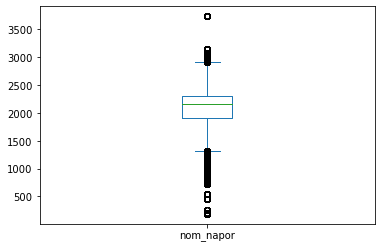

In [46]:
raw_data_train['nom_napor'].plot.box()
plt.show()

Напор номин. меньше 500 m является аномальным значением.

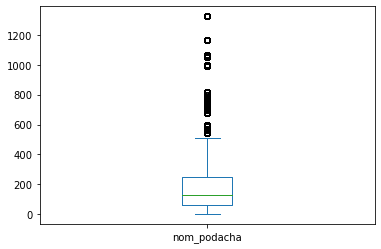

In [47]:
raw_data_train['nom_podacha'].plot.box()
plt.show()

Подача Q меньше 50 т/сут и более 500 т/сут является аномальным значением.

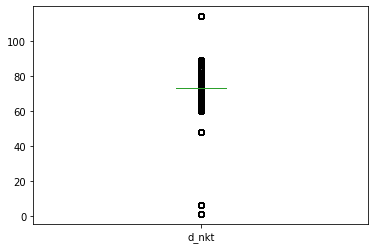

In [48]:
raw_data_train['d_nkt'].plot.box()
plt.show()

Диаметр НКТ меньше 33 мм является аномальным значением.

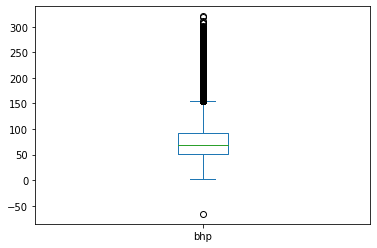

In [49]:
raw_data_train['bhp'].plot.box()
plt.show()

Давление на забое скважины не может быть меньше 0. Отрицательное значение является аномальным.

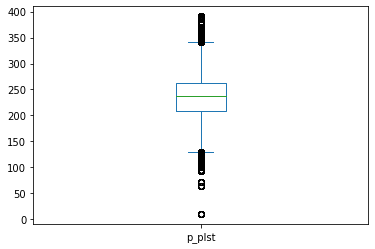

In [50]:
raw_data_train['p_plst'].plot.box()
plt.show()

Давление пластовое не может быть ниже 50 атм. Значение 9 атм является аномальным. 

In [51]:
pd.options.mode.chained_assignment = None  # default='warn'

In [52]:
missing_values_table(raw_data_train)

Датафрейм имеет 34 колонок.
25 колонок имеют пропущенные значения.


,Missing Values,% of Total Values
p_zatr,2609862,93.8
h_din,2609862,93.8
bhp,2236826,80.4
water_cut,1722099,61.9
q_ois,1480080,53.2
inject_3,1231026,44.2
inject_1,1167823,42.0
inject_0,1155801,41.5
inject_2,1133566,40.7
nom_moschn,164778,5.9


В колонке **state** всего две категории данных: 1 и 0. Можно предположить, что это состояние скважины в работе/в бездействии.

In [53]:
state_0 = raw_data_train.query('state == 0')

In [54]:
# state_0.isna().sum()

Состояние в бездействии означает отсутствие замеров в данный период времени, пропуски логично заменить на 0.

In [55]:
state_0 = state_0.fillna(0)

In [56]:
# state_0

In [57]:
state_1 = raw_data_train.query('state == 1')

In [58]:
# state_1

Последующее заполнение пропусков произведем на ближайшее непропущенное значение. Поэтому необходимо отсортировать данные по дате замеров и по id.

In [59]:
data_train_upd = pd.concat([state_1,state_0]).sort_values(by=['id','date']).reset_index(drop=True)
# data_train_upd

In [60]:
# missing_values_table(data_train_upd)

In [61]:
data_train_upd = data_train_upd.fillna(method='ffill')
# data_train_upd

In [62]:
data_train_upd.isna().sum()

d_nytr             0
h_din              0
q_ois              0
nom_moschn         0
h_perf             0
nom_napor          0
water_cut          0
nom_podacha        0
d_nkt              0
h_sp               0
p_plst             0
h_vd               0
extend_hvd         0
pl_neft            0
vyazk_neft         0
sum_tolshin        0
p_zatr             0
pl_vody            0
p_nas              0
inject_0         176
inject_1         176
inject_2         176
inject_3         176
bhp              176
state              0
idn_type           0
nalich_sep         0
formation_lbl      0
state_age          0
date               0
start_date         0
well_id            0
id                 0
vnr                0
dtype: int64

Пропусков осталось не так много и их можно удалить.

In [63]:
data_train_upd = data_train_upd.dropna().reset_index(drop=True)

In [64]:
# raw_data_train.describe()

In [65]:
# data_train_upd.describe()

In [66]:
print('Значение среднего дебита жидкости после обработки пропусков и аномалий изменилось на:\n',
      (data_train_upd['q_ois'].mean()-raw_data_train['q_ois'].mean())/raw_data_train['q_ois'].mean()*100, '%')

Значение среднего дебита жидкости после обработки пропусков и аномалий изменилось на:
 18.969488195397197 %


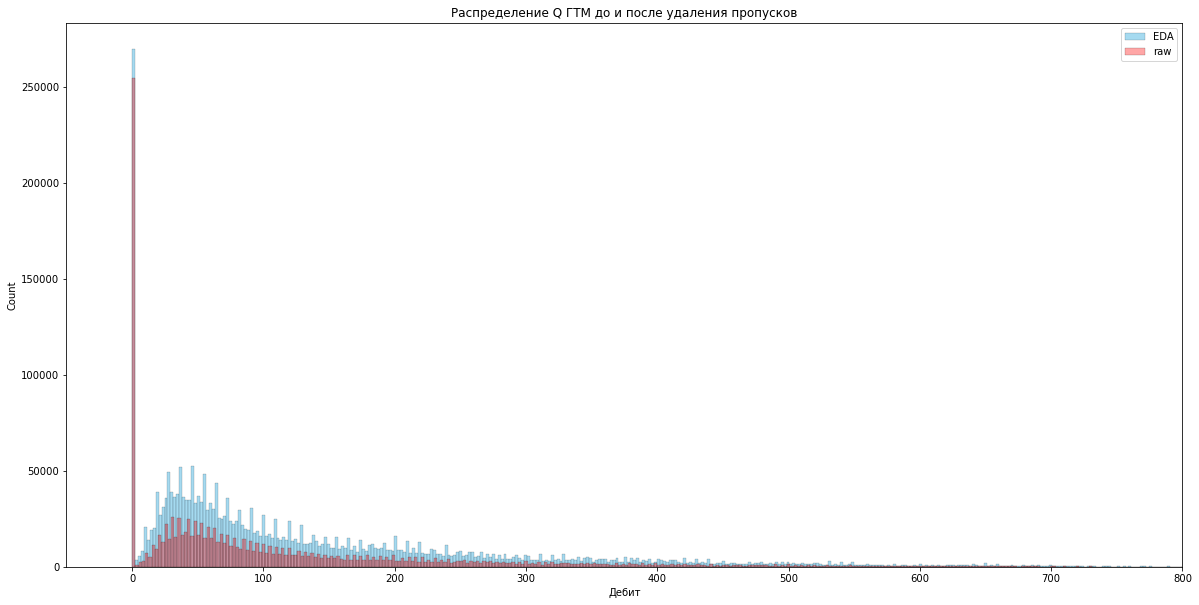

In [67]:
plt.figure(figsize=(20, 10))
sns.histplot(data_train_upd['q_ois'], color="skyblue", label="EDA")
sns.histplot(raw_data_train['q_ois'], color="red", label="raw", alpha = 0.35)\
             .set(xlabel='Дебит', xlim=(-50, 800), title='Распределение Q ГТМ до и после удаления пропусков')
plt.legend()
plt.show()

Распределение пропусков до и после обработки имеют схожую форму.

Отделим аномальные значения, но перед этим посчитаем количество остановок для каждого ГТМ

In [68]:
data_train_upd['state_0_count'] = data_train_upd.groupby('id')['state'].\
                                                transform(lambda x: (x==0).sum())

In [69]:
data_train_upd = data_train_upd [(data_train_upd['nom_napor'] >= 500) & (data_train_upd['nom_podacha'] >= 50)&\
                            (data_train_upd['d_nkt'] >= 33) & (data_train_upd['bhp'] > 0)&\
                            (data_train_upd['p_plst'] >= 50)].reset_index(drop=True)

## Исследование корреляций. Тепловая карта

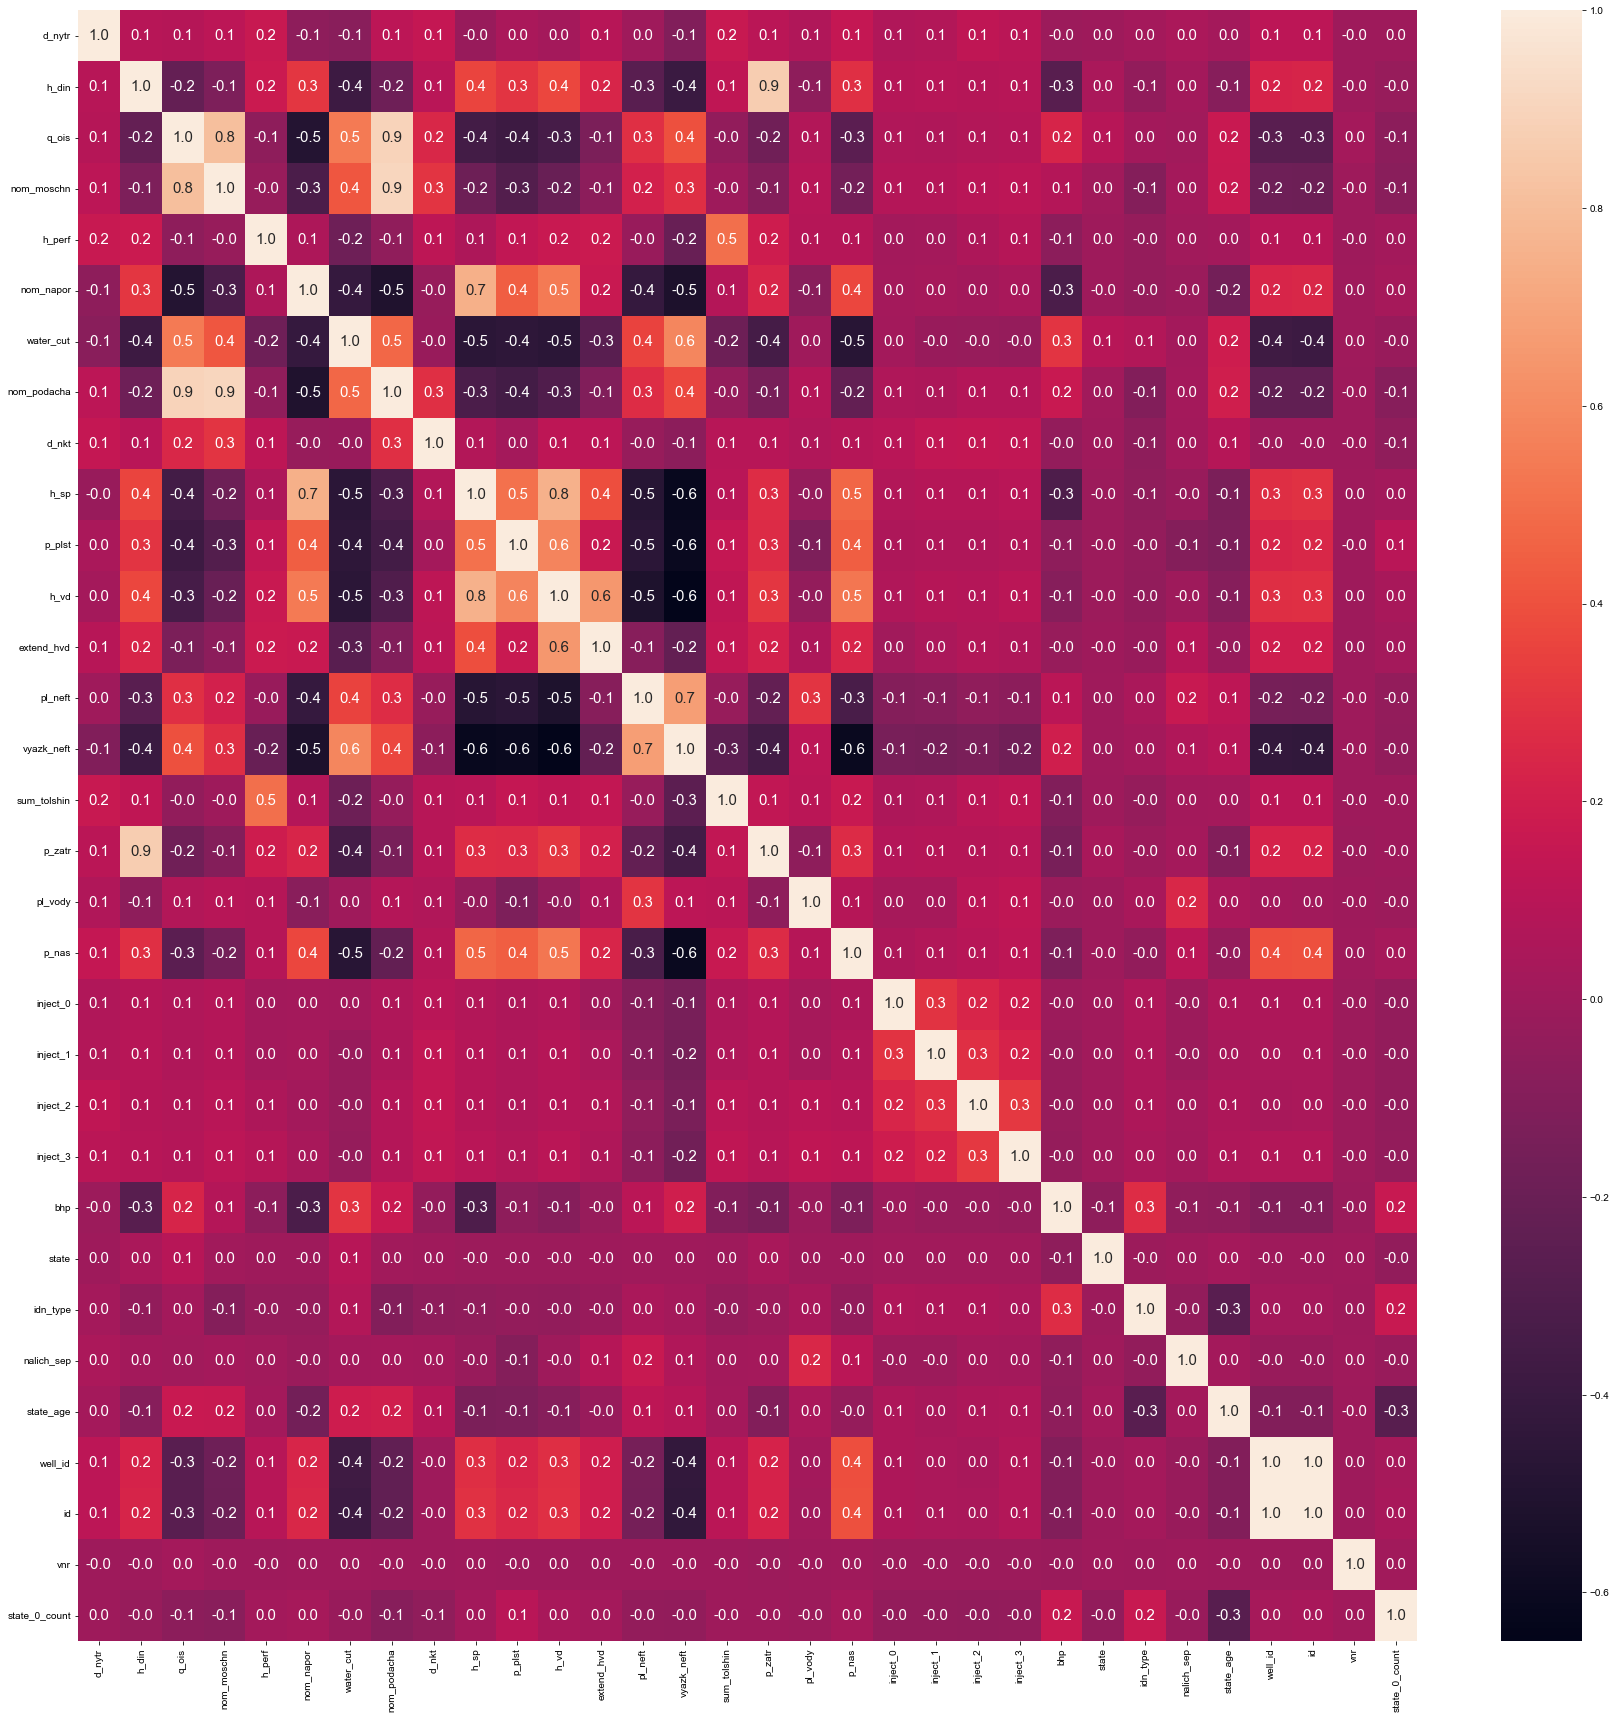

In [70]:
fig, ax = plt.subplots(figsize=(30, 30))
sns.heatmap(data_train_upd.corr(), annot=True, fmt='.1f', ax=ax, annot_kws={"fontsize":15})
sns.set(font_scale=1)
plt.show()

Целевой признак Q_ois сильно коррелирует с номинальной мощностью, номинальной подачей, обводненностью. Слабо коррелирует с суммой нефтенасыщенных толщин, наличием сепаратора, глубиной перфорации, типом ИДН и выходом на режим.

Сильная корреляция наблюдается между парами признаков:
- ном.мощность - ном.подача,
- Hdin - p_zatr
- ном напор - глубина спуска h_sp
- d_nkt - плоность нефти и плотность воды
- p_plst - глуб верх дыр h_vd, плотность нефти и плотность воды
- h_vd - p_plst, p_nas, плотность нефти и плотность воды
- плотность нефти - d_nytr, d_nkt, h_vd и плотность воды
- плотность воды - d_nkt, p_plst, h_vd, p_nas
- p_nas - d_nkt, p_plst, h_vd, плотность воды

Выполним удаление сильно коррелирующих признаков **'nom_moschn','h_sp','h_vd','d_nkt','p_zatr'** и слабо коррелирующих **'sum_tolshin','h_perf','nalich_sep'** с целевой переменной.

In [71]:
data_train_upd = data_train_upd.drop(['nom_moschn','h_sp','h_vd','d_nkt','pl_vody','p_zatr',\
                                      'sum_tolshin','idn_type','h_perf','nalich_sep'],\
                                     axis = 1)

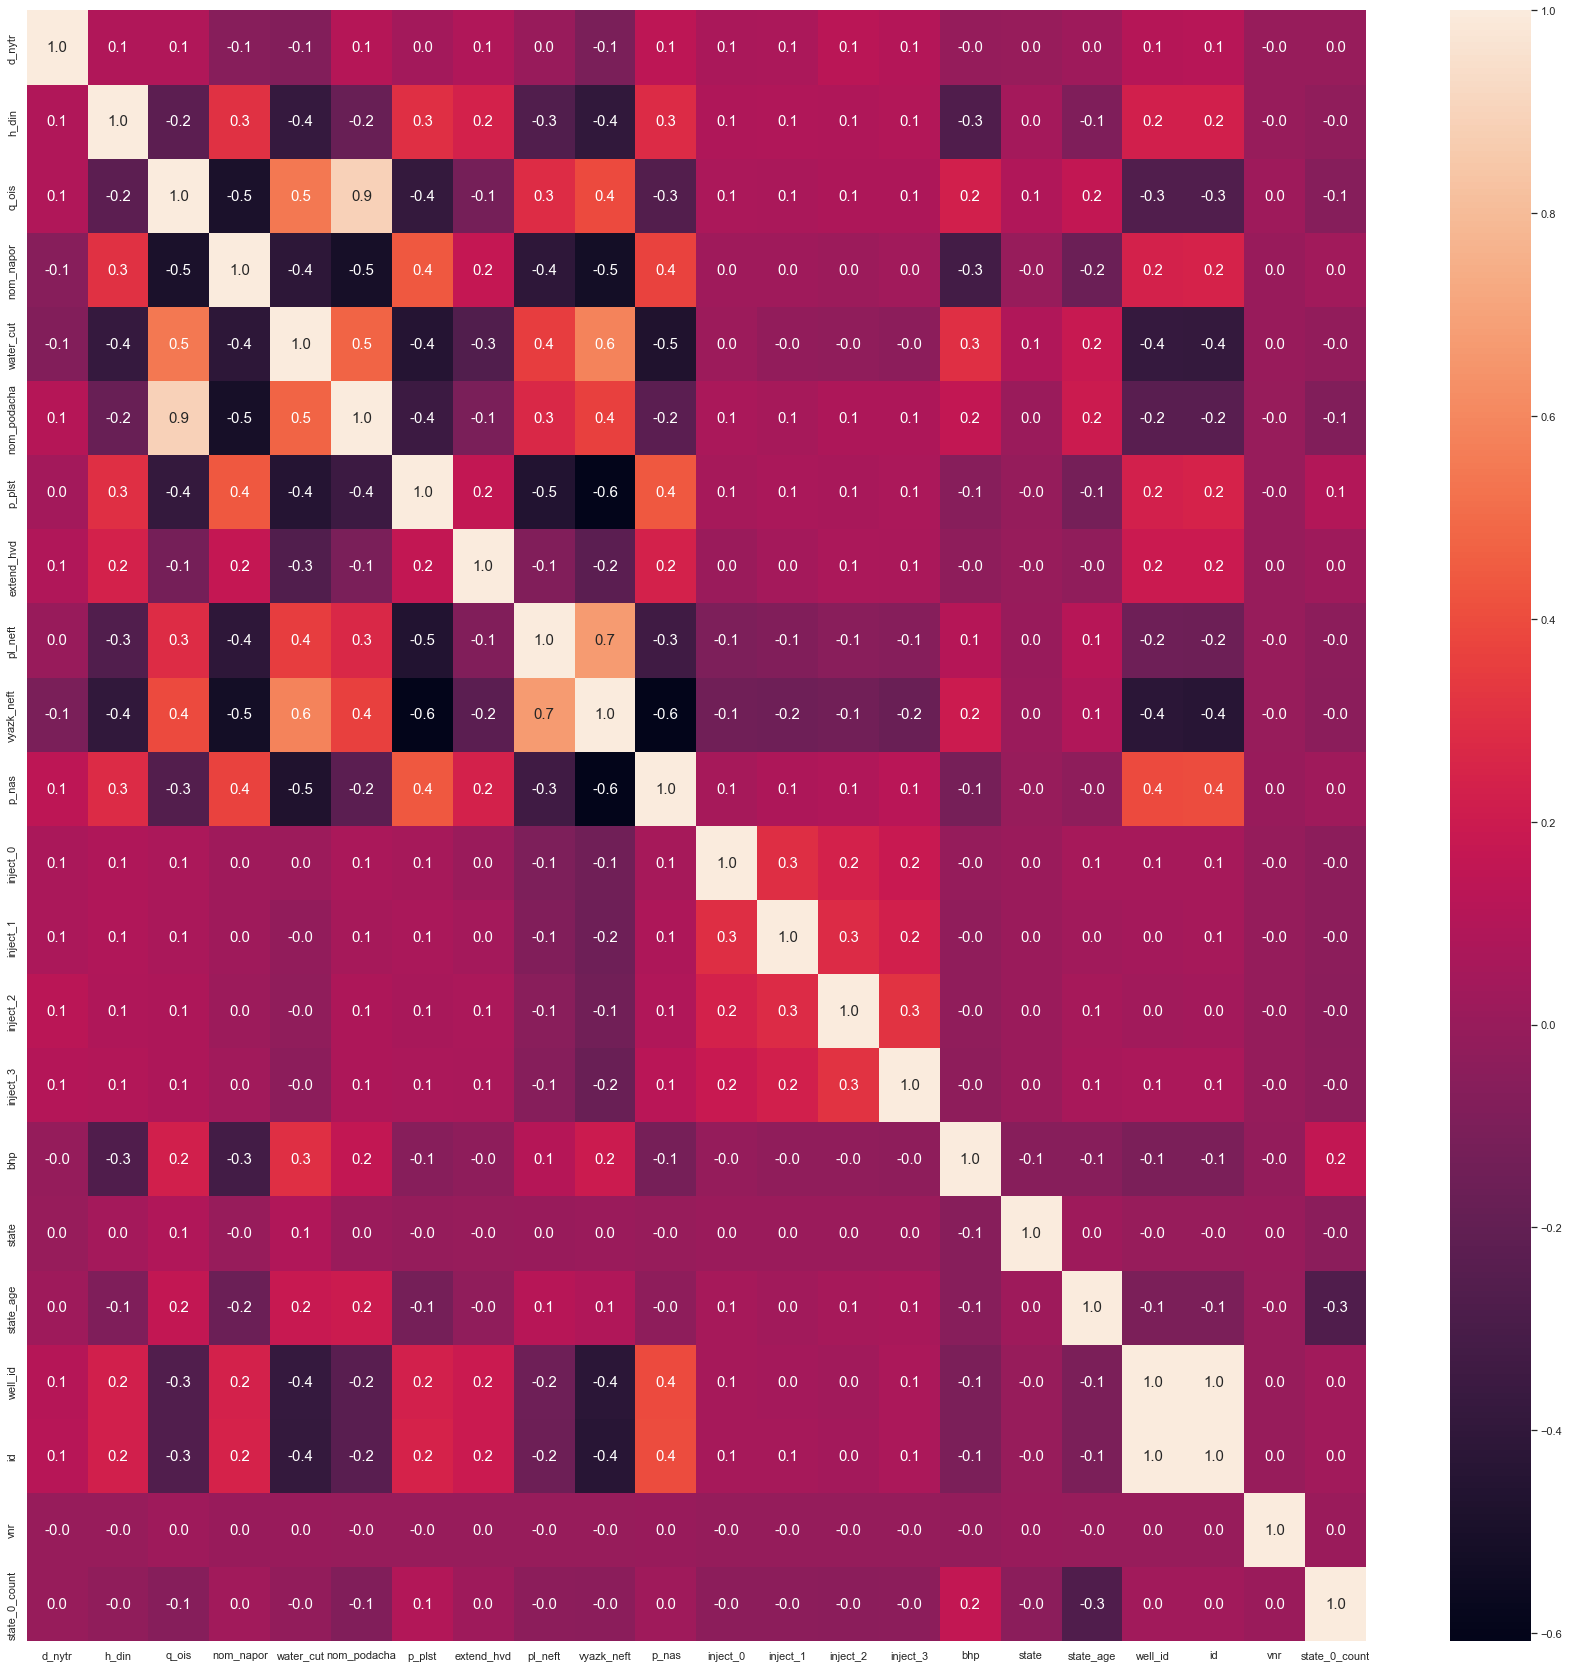

In [72]:
fig, ax = plt.subplots(figsize=(30, 30))
sns.heatmap(data_train_upd.corr(), annot=True, fmt='.1f', ax=ax, annot_kws={"fontsize":15})
sns.set(font_scale=1)
plt.show()

## Подготовка признаков

Выполним объединение тренировочного датафрейма с данными о ГТМ.

In [73]:
data_train_upd.head()

,d_nytr,h_din,q_ois,nom_napor,water_cut,nom_podacha,p_plst,extend_hvd,pl_neft,vyazk_neft,...,bhp,state,formation_lbl,state_age,date,start_date,well_id,id,vnr,state_0_count
0,223.0,1765.0,0.0,1710.0,88.0,1167.0,162.0,161.9,0.876,2.91,...,98.820447,0,25,711.0,1973-10-03,1973-10-04,0,2,0,8
1,130.6,0.0,427.0,1680.0,81.0,464.0,159.0,4.6,0.876,2.91,...,47.040000,1,25,555.0,1974-10-07,1975-03-26,1,5,0,9
2,130.6,0.0,427.0,1680.0,81.0,464.0,159.0,4.6,0.876,2.91,...,47.040000,1,25,555.0,1974-10-08,1975-03-26,1,5,0,9
3,130.6,0.0,427.0,1680.0,81.0,464.0,159.0,4.6,0.876,2.91,...,47.040000,1,25,555.0,1974-10-09,1975-03-26,1,5,0,9
4,130.6,0.0,427.0,1680.0,81.0,464.0,159.0,4.6,0.876,2.91,...,47.040000,1,25,555.0,1974-10-10,1975-03-26,1,5,0,9


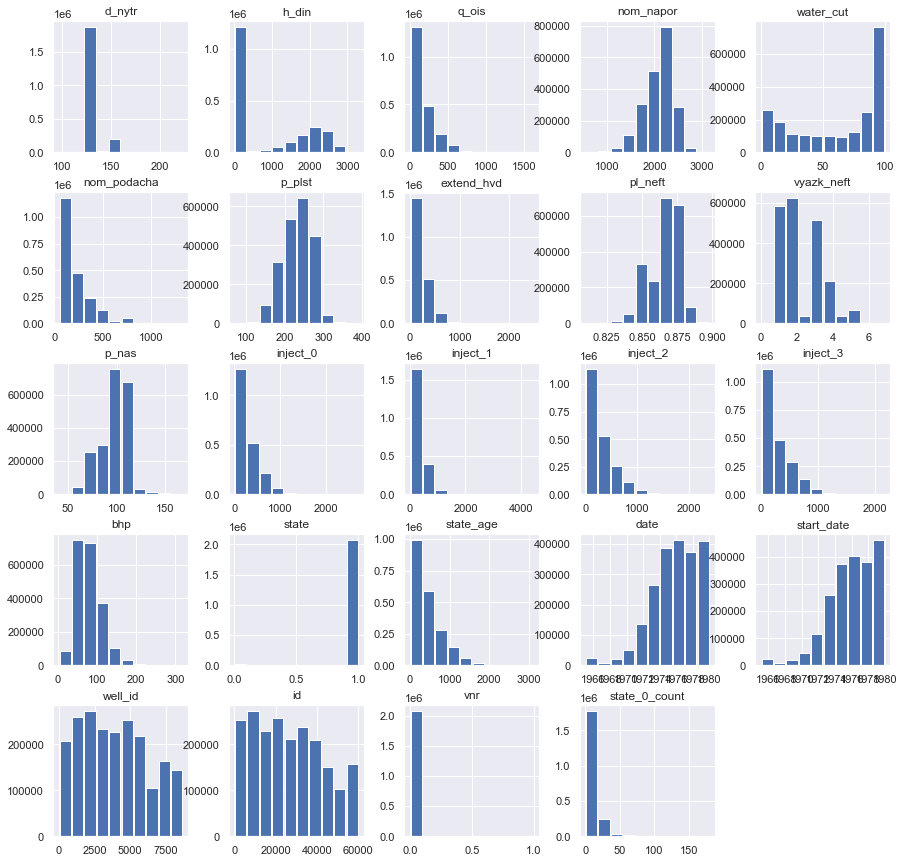

In [74]:
data_train_upd.hist(figsize=(15, 15), rwidth=0.9)
plt.show()

In [75]:
data_train_merge = data_train_upd.merge(data_gtm, on = ['well_id','start_date'], how = 'left')

In [76]:
# data_train_merge

Появилась нестыковка по длине датафрейма, ниже видим что для гтм № 33424 увеличилось количество данных.

In [77]:
# data_train_upd['id'].value_counts()

In [78]:
# data_train_merge['id'].value_counts()

Видим, что для данного id было проведено два типа ГТМ.

In [79]:
# data_train_merge[data_train_merge['id'] == 33424]

Поскольку для нас интерес представляют только ГТМ типа 2 и 7, их и оставляем (№9, который появился при слиянии таблиц, удалим)

In [80]:
# data_train_merge[(data_train_merge['gtm_type_lbl'] != 2)&(data_train_merge['gtm_type_lbl'] != 7)]

In [81]:
data_train_merge = data_train_merge.query('gtm_type_lbl !=9')

In [82]:
data_train_merge = data_train_merge.sort_values(by=['id','date']).reset_index(drop=True)
# data_train_merge

Построим график изменения q_ois для ГТМ №20526. Также видим, что для каждого id есть только один выход на режим ВНР.

In [83]:
id_20526 = data_train_merge[data_train_merge['id'] == 20526]
id_20526

,d_nytr,h_din,q_ois,nom_napor,water_cut,nom_podacha,p_plst,extend_hvd,pl_neft,vyazk_neft,...,formation_lbl,state_age,date,start_date,well_id,id,vnr,state_0_count,date_vnr,gtm_type_lbl
873020,129.0,0.0,0.0,2200.0,0.0,200.0,274.0,5.45,0.851,1.1,...,18,171.0,1974-05-20,1974-11-15,3057,20526,0,12,1974-11-20,7
873021,129.0,0.0,53.0,2200.0,1.0,200.0,274.0,5.45,0.851,1.1,...,18,171.0,1974-05-27,1974-11-15,3057,20526,0,12,1974-11-20,7
873022,129.0,0.0,58.0,2200.0,1.0,200.0,274.0,5.45,0.851,1.1,...,18,171.0,1974-05-28,1974-11-15,3057,20526,0,12,1974-11-20,7
873023,129.0,0.0,58.0,2200.0,1.0,200.0,274.0,5.45,0.851,1.1,...,18,171.0,1974-05-29,1974-11-15,3057,20526,0,12,1974-11-20,7
873024,129.0,0.0,62.0,2200.0,1.0,200.0,274.0,5.45,0.851,1.1,...,18,171.0,1974-05-30,1974-11-15,3057,20526,0,12,1974-11-20,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
873189,129.0,0.0,42.0,2510.0,9.0,50.0,275.0,5.45,0.851,1.1,...,18,171.0,1974-11-11,1974-11-15,3057,20526,0,12,1974-11-20,7
873190,129.0,0.0,43.0,2510.0,9.0,50.0,275.0,5.45,0.851,1.1,...,18,171.0,1974-11-12,1974-11-15,3057,20526,0,12,1974-11-20,7
873191,129.0,0.0,43.0,2510.0,9.0,50.0,275.0,5.45,0.851,1.1,...,18,171.0,1974-11-13,1974-11-15,3057,20526,0,12,1974-11-20,7
873192,129.0,0.0,30.0,2510.0,9.0,50.0,275.0,5.45,0.851,1.1,...,18,171.0,1974-11-14,1974-11-15,3057,20526,0,12,1974-11-20,7


In [84]:
id_20526.query('vnr == 1')

,d_nytr,h_din,q_ois,nom_napor,water_cut,nom_podacha,p_plst,extend_hvd,pl_neft,vyazk_neft,...,formation_lbl,state_age,date,start_date,well_id,id,vnr,state_0_count,date_vnr,gtm_type_lbl
873193,129.0,0.0,47.0,2510.0,9.0,50.0,275.0,5.45,0.851,1.1,...,18,171.0,1974-11-20,1974-11-15,3057,20526,1,12,1974-11-20,7


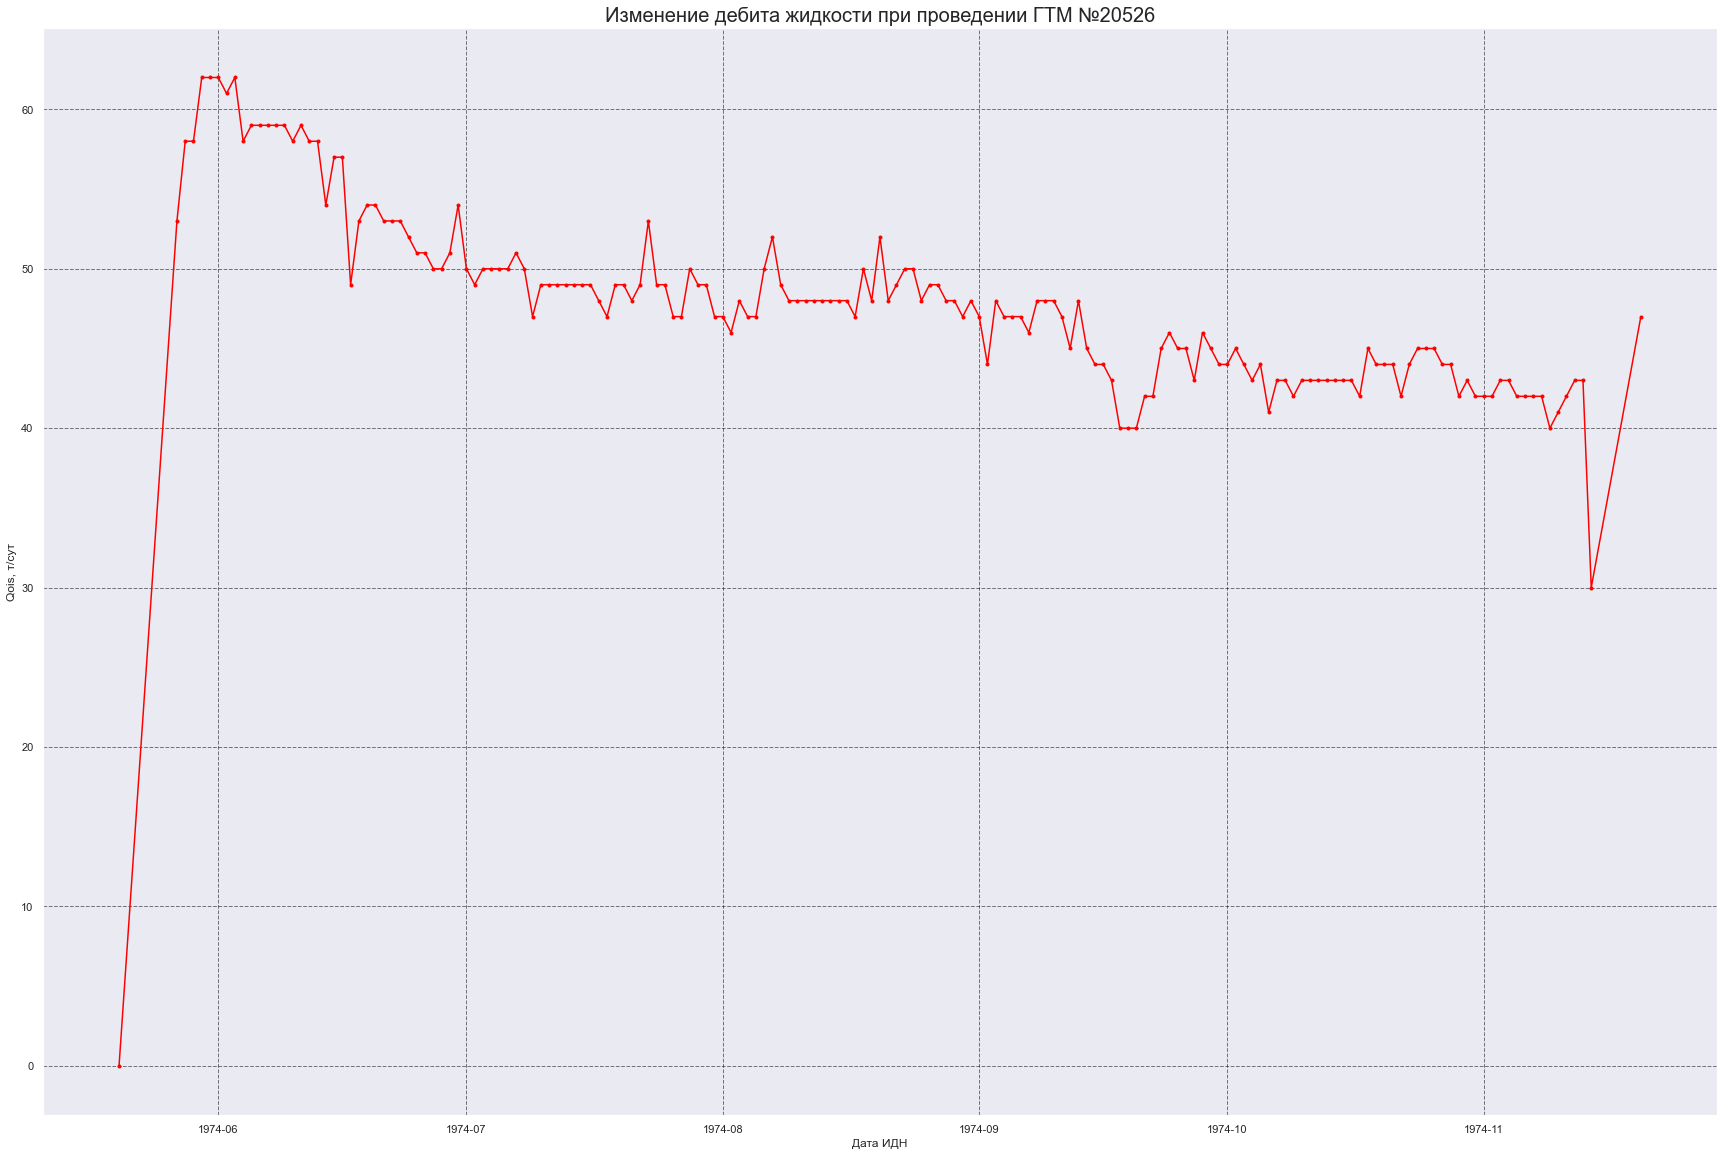

In [85]:
fig, ax = plt.subplots(figsize=(30, 20))
ax.set_ylabel("Qois, т/сут")
ax.set_xlabel('Дата ИДН')
ax.set_title('Изменение дебита жидкости при проведении ГТМ №20526',fontsize = 20)
ax.grid(color='black',linestyle = "dashed",alpha = 0.5)

xmin = id_20526['date'].min()
xmax = id_20526['date'].max()

x = id_20526['date']
y = id_20526['q_ois']

p1 = ax.plot(x, y,'.-', c='red')

plt.show()

In [86]:
# id_37845 = data_train_merge[data_train_merge['id'] == 37845][['date','start_date','date_vnr','q_ois','state','vnr']]
# id_37845

In [87]:
# fig, ax = plt.subplots(figsize=(30, 20))
# ax.set_ylabel("Qois, т/сут")
# ax.set_xlabel('Дата ИДН')
# ax.set_title('Изменение дебита жидкости при проведении ГТМ №37845',fontsize = 20)
# ax.grid()

# xmin = id_37845['date'].min()
# xmax = id_37845['date'].max()

# x = id_37845['date']
# y = id_37845['q_ois']

# p1 = ax.plot(x, y,'.-', c='red')

# plt.show()

In [88]:
# id_42408 = data_train_merge[data_train_merge['id'] == 42408][['date','start_date','date_vnr','q_ois','state','vnr']]
# id_42408

In [89]:
# fig, ax = plt.subplots(figsize=(30, 20))
# ax.set_ylabel("Qois, т/сут")
# ax.set_xlabel('Дата ИДН')
# ax.set_title('Изменение дебита жидкости при проведении ГТМ №42408',fontsize = 20)
# ax.grid()

# xmin = id_42408['date'].min()
# xmax = id_42408['date'].max()

# x = id_42408['date']
# y = id_42408['q_ois']

# p1 = ax.plot(x, y,'.-', c='red')

# plt.show()

In [90]:
data_train_merge['vnr_count'] = data_train_merge.groupby('well_id')['vnr'].transform( lambda x: x.sum())

Данный признак нужен, чтобы понять, сколько выходов на режим может быть на скважине - максимально 9.

In [91]:
data_train_merge['vnr_count'].value_counts()

2    580668
1    527450
3    482826
4    256390
5    125879
0     63022
6     32225
7     14032
8      2849
Name: vnr_count, dtype: int64

In [92]:
data_train_merge['vnr_count_id'] = data_train_merge.groupby('id')['vnr'].transform( lambda x: (x==1).sum())

In [93]:
data_train_merge['vnr_count_id'].value_counts()

1    1818838
0     266503
Name: vnr_count_id, dtype: int64

Для каждого ГТМ есть только один ВНР, для каждой скважины может быть несколько ВНР (макс.9)

In [94]:
# data_train_merge.query('vnr_count_id == 0 & vnr == 1')

In [95]:
# data_train_merge

In [96]:
# data_train_merge.query('vnr==1')

In [97]:
# data_train_merge.query('vnr==1')['vnr_count'].unique()

In [98]:
# data_gtm

In [99]:
# data_train_merge['well_id'].value_counts()

Построила зависимость q_ois для скважины #4 для того, чтобы посмотреть каким образом визуализируется внр.

In [100]:
well_4 = data_train_merge[data_train_merge['well_id'] == 4][['date','start_date','date_vnr','q_ois','state','vnr']]
well_4

,date,start_date,date_vnr,q_ois,state,vnr
684,1971-12-10,1972-05-26,1972-06-08,1270.0,1,0
685,1971-12-11,1972-05-26,1972-06-08,1270.0,1,0
686,1971-12-12,1972-05-26,1972-06-08,1270.0,1,0
687,1971-12-13,1972-05-26,1972-06-08,1270.0,1,0
688,1971-12-14,1972-05-26,1972-06-08,1270.0,1,0
...,...,...,...,...,...,...
1157,1975-04-12,1975-04-16,1975-05-27,1260.0,1,0
1158,1975-04-13,1975-04-16,1975-05-27,1260.0,1,0
1159,1975-04-14,1975-04-16,1975-05-27,1153.0,1,0
1160,1975-04-15,1975-04-16,1975-05-27,1011.0,1,0


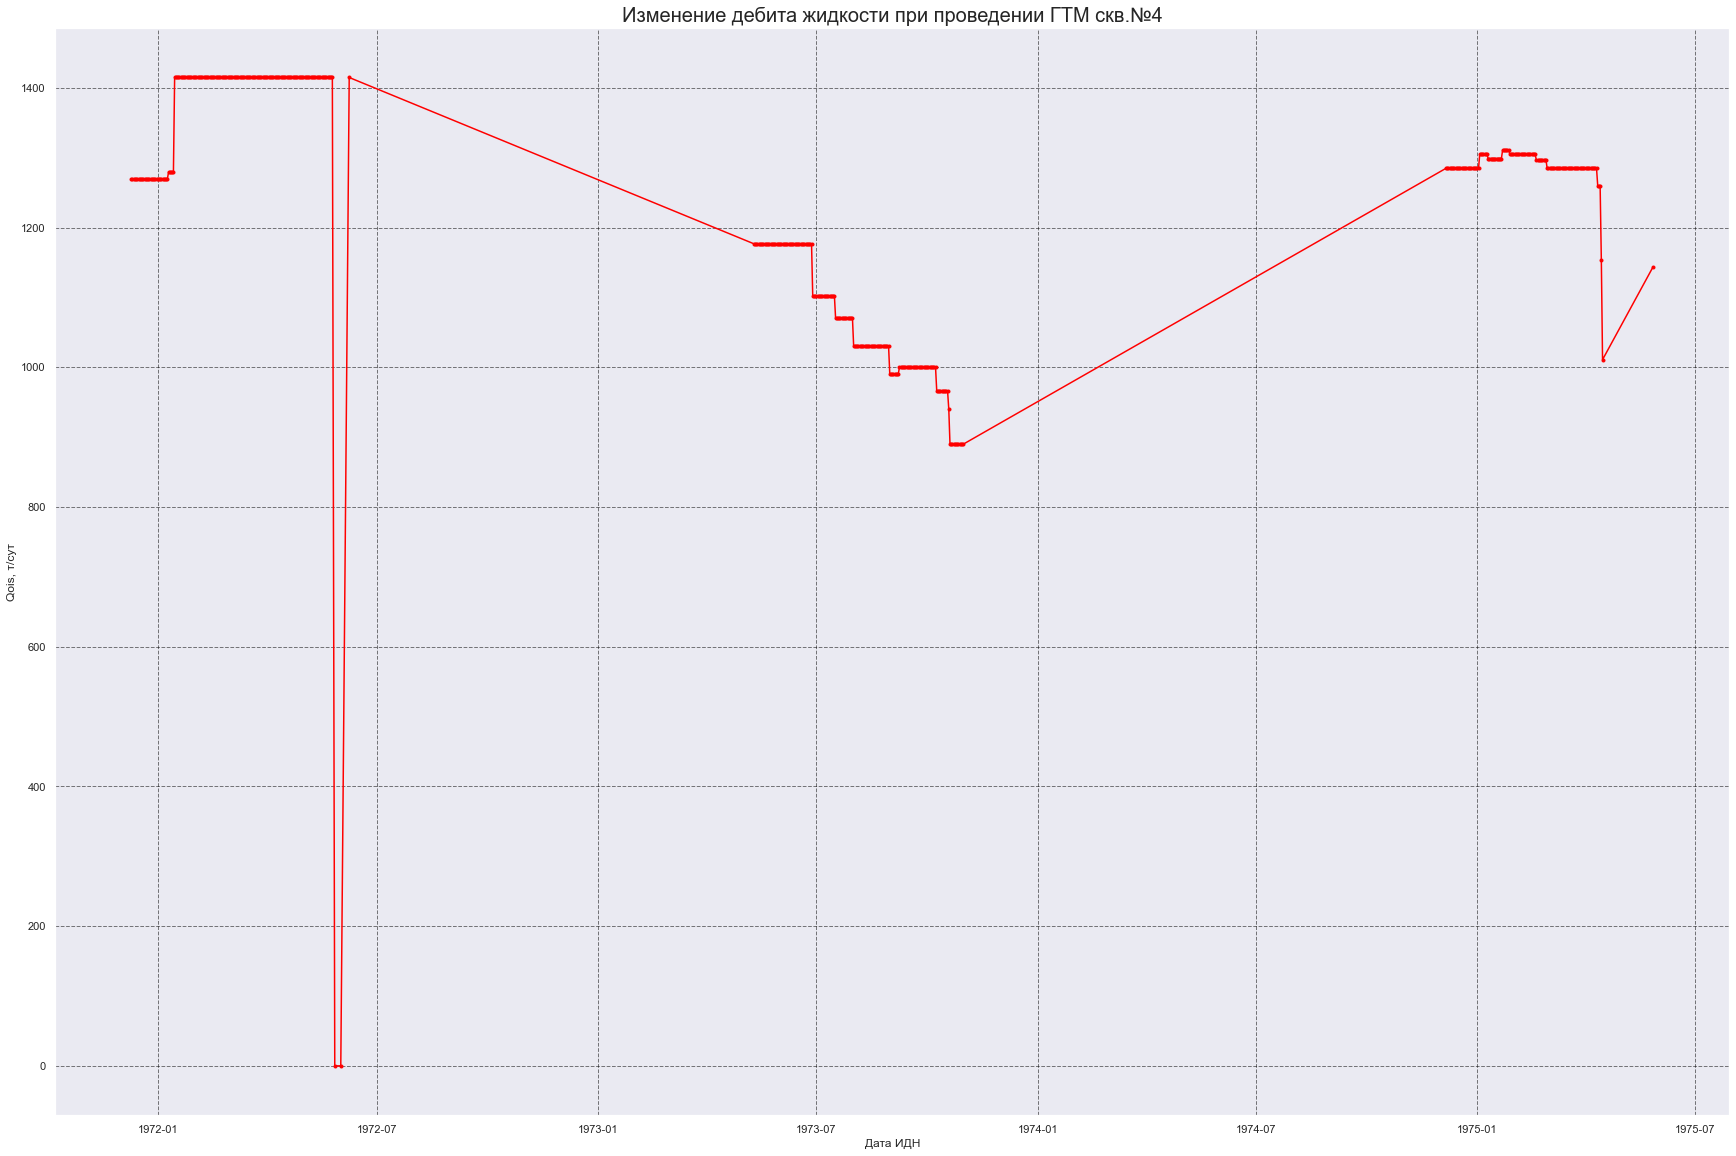

In [101]:
fig, ax = plt.subplots(figsize=(30, 20))
ax.set_ylabel("Qois, т/сут")
ax.set_xlabel('Дата ИДН')
ax.set_title('Изменение дебита жидкости при проведении ГТМ скв.№4',fontsize = 20)
ax.grid(color='black',linestyle = "dashed",alpha = 0.5)

xmin = well_4['date'].min()
xmax = well_4['date'].mean()

x = well_4['date']
y = well_4['q_ois']

p1 = ax.plot(x, y,'.-', c='red')

plt.show()

Видим периоды падений. Количество внр равно 3.

In [102]:
data_train_merge.query('vnr_count==3')['well_id'].unique()

array([  17,   20,   40,   59,   68,   72,   78,   87,   90,  105,  132,
        133,  134,  138,  140,  145,  150,  154,  156,  159,  168,  169,
        171,  175,  176,  182,  214,  224,  226,  227,  232,  261,  274,
        275,  281,  284,  292,  297,  298,  301,  309,  311,  313,  324,
        340,  344,  348,  349,  352,  359,  367,  380,  382,  383,  393,
        396,  404,  419,  426,  427,  428,  433,  440,  461,  465,  470,
        489,  495,  671,  679,  681,  694,  727,  729,  744,  747,  760,
        766,  795,  798,  813,  828,  844,  849,  854,  857,  864,  873,
        874,  880,  883,  884,  928,  931,  973,  978,  990,  992,  997,
       1001, 1007, 1009, 1023, 1068, 1070, 1083, 1099, 1122, 1153, 1166,
       1178, 1180, 1184, 1191, 1193, 1198, 1201, 1206, 1207, 1208, 1213,
       1232, 1234, 1236, 1242, 1246, 1247, 1250, 1254, 1256, 1258, 1260,
       1275, 1277, 1282, 1288, 1289, 1291, 1295, 1301, 1304, 1307, 1310,
       1357, 1367, 1379, 1380, 1383, 1391, 1395, 13

Определим количество дней непрерывной работы до внр.

In [103]:
data_train_merge['days'] = (data_train_merge['date_vnr'] - \
                            data_train_merge.groupby('id')['date'].transform( lambda x: x.min())).dt.total_seconds()/60/60/24

In [104]:
data_train_merge['days']

0            8.0
1          179.0
2          179.0
3          179.0
4          179.0
           ...  
2085336    183.0
2085337    183.0
2085338    183.0
2085339    183.0
2085340    183.0
Name: days, Length: 2085341, dtype: float64

Далее проведем генерацию новых признаков статистик исторических данных в разрезе каждого гтм.

In [105]:
data_train_merge.index = data_train_merge['date']

Добавим в тренировочный датасет календарные признаки, а также признаки смещения и плавающего среднего дебита скважины с окном 7, 30 и 90 дней.

In [106]:
def make_features(data, max_lag, max_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data.groupby('id')['q_ois'].transform(lambda x: x.shift(lag))
        data['lag_{}'.format(lag)] = data.groupby('id')['bhp'].transform(lambda x: x.shift(lag))
        
    for size in [max_size * 7,max_size * 30]:

        data['rol_mean_q_{}'.format(size)] = data.groupby('id')['q_ois'].transform(lambda x: x.rolling(size).mean())

        data['rol_mean_wc_{}'.format(size)] = data.groupby('id')['water_cut'].\
                                                transform(lambda x: x.rolling(size).mean())
        
        data['rol_mean_inj_0_{}'.format(size)] = data.groupby('id')['inject_0'].\
                                                transform(lambda x: x.rolling(size).mean())
        data['rol_mean_inj_1_{}'.format(size)] = data.groupby('id')['inject_1'].\
                                                transform(lambda x: x.rolling(size).mean())
        data['rol_mean_inj_2_{}'.format(size)] = data.groupby('id')['inject_2'].\
                                                transform(lambda x: x.rolling(size).mean())
        data['rol_mean_inj_3_{}'.format(size)] = data.groupby('id')['inject_3'].\
                                                transform(lambda x: x.rolling(size).mean())
        
        data['rol_mean_bhp_{}'.format(size)] = data.groupby('id')['bhp'].transform(lambda x: x.rolling(size).mean())
        
    data['nom_napor_mean'] = data.groupby('id')['nom_napor'].transform(lambda x: x.mean())
    data['nom_podacha_mean'] = data.groupby('id')['nom_podacha'].transform(lambda x: x.mean())
    data['nom_p_plst_mean'] = data.groupby('id')['p_plst'].transform(lambda x: x.mean())    

Для добавления смещения и правающего среднего были выбраны наиболее изменяемые признаки: Q_ois, wc, inject и bhp. Напор, подача и пластовое давление также изменяются но не настолько сильно, имеют около 3 разных значений. Поэтому на их основе новым признаком выбрала среднее.

Размер окна выбирала исходя из логики: 1 неделя, 1 месяц, 1 квартал.

In [107]:
data_x = data_train_merge

In [108]:
make_features(data_x, 7, 1)

In [109]:
data_x

,d_nytr,h_din,q_ois,nom_napor,water_cut,nom_podacha,p_plst,extend_hvd,pl_neft,vyazk_neft,...,rol_mean_q_30,rol_mean_wc_30,rol_mean_inj_0_30,rol_mean_inj_1_30,rol_mean_inj_2_30,rol_mean_inj_3_30,rol_mean_bhp_30,nom_napor_mean,nom_podacha_mean,nom_p_plst_mean
date,,,,,,,,,,,,,,,,,,,,,
1973-10-03,223.0,1765.0,0.0,1710.0,88.0,1167.0,162.0,161.90000,0.876,2.91,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1710.0,1167.0,162.000000
1974-10-07,130.6,0.0,427.0,1680.0,81.0,464.0,159.0,4.60000,0.876,2.91,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1680.0,464.0,156.081871
1974-10-08,130.6,0.0,427.0,1680.0,81.0,464.0,159.0,4.60000,0.876,2.91,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1680.0,464.0,156.081871
1974-10-09,130.6,0.0,427.0,1680.0,81.0,464.0,159.0,4.60000,0.876,2.91,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1680.0,464.0,156.081871
1974-10-10,130.6,0.0,427.0,1680.0,81.0,464.0,159.0,4.60000,0.876,2.91,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1680.0,464.0,156.081871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1979-04-11,132.0,2342.0,41.0,1716.0,76.0,125.0,295.0,416.30415,0.849,0.98,...,41.666667,76.000000,181.725584,98.366667,134.473749,217.156507,88.444333,1716.0,125.0,301.421348
1979-04-12,132.0,2342.0,41.0,1716.0,76.0,125.0,295.0,416.30415,0.849,0.98,...,41.600000,76.000000,181.827809,98.366667,133.864220,215.986059,88.448667,1716.0,125.0,301.421348
1979-04-13,132.0,2342.0,41.0,1716.0,76.0,125.0,295.0,416.30415,0.849,0.98,...,41.533333,76.000000,181.930033,98.366667,133.254690,214.815610,88.453000,1716.0,125.0,301.421348


In [110]:
# data_x.query('id==7420')[['q_ois','rol_mean_q_7','rol_mean_q_30']]

In [111]:
data_x = data_x.dropna()

In [112]:
data_train = data_x[data_x['vnr'] == 1].reset_index(drop=True)

Данный фильтр необходим для отделения даты ВНР, на которую и должен быть выполнен прогноз.

In [113]:
data_train

,d_nytr,h_din,q_ois,nom_napor,water_cut,nom_podacha,p_plst,extend_hvd,pl_neft,vyazk_neft,...,rol_mean_q_30,rol_mean_wc_30,rol_mean_inj_0_30,rol_mean_inj_1_30,rol_mean_inj_2_30,rol_mean_inj_3_30,rol_mean_bhp_30,nom_napor_mean,nom_podacha_mean,nom_p_plst_mean
0,130.6,0.0,304.0,1680.0,71.0,464.0,154.0,4.60000,0.876,2.91,...,404.300000,79.766667,0.000000,0.000000,0.000000,0.000000,49.055667,1680.000000,464.000000,156.081871
1,222.9,0.0,1118.0,1710.0,80.0,1167.0,168.0,533.44000,0.876,2.91,...,1035.366667,74.333333,0.000000,0.000000,0.000000,0.000000,85.755333,1710.000000,1167.000000,168.502825
2,222.8,2084.0,1100.0,1710.0,92.0,1167.0,166.0,649.30000,0.876,2.91,...,1015.333333,86.233333,142.012401,0.000000,0.000000,0.000000,89.619000,1710.000000,1167.000000,167.141975
3,223.0,1596.0,1415.0,1710.0,82.0,1167.0,213.0,513.20000,0.873,2.91,...,1320.666667,76.533333,116.580000,0.000000,0.000000,0.000000,103.991333,1710.000000,1167.000000,212.666667
4,223.0,1780.0,1144.0,1710.0,92.0,1167.0,192.0,513.20000,0.876,2.91,...,1264.266667,91.466667,0.000000,0.000000,0.000000,0.000000,85.987000,1710.000000,1167.000000,193.363636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11275,132.0,1288.0,104.0,1814.0,46.0,50.0,205.0,135.00000,0.849,0.98,...,66.233333,43.333333,0.000000,0.000000,66.616356,266.535484,94.261134,1852.294118,54.117647,205.000000
11276,127.0,0.0,47.0,2032.0,29.0,80.0,221.0,7.51000,0.849,0.98,...,40.833333,24.466667,0.000000,0.000000,91.616359,353.541897,41.944000,2032.000000,80.000000,204.177143
11277,130.6,1485.0,76.0,1352.0,90.0,60.0,229.0,309.93400,0.849,0.98,...,41.100000,90.500000,0.000000,375.909140,273.629743,0.000000,150.052649,1352.000000,60.000000,229.563218
11278,130.6,1741.0,59.0,1872.0,92.0,80.0,218.0,309.93400,0.849,0.98,...,49.933333,91.366667,0.000000,327.742366,297.981212,0.000000,80.228642,1872.000000,80.000000,218.000000


In [114]:
data_train.columns

Index(['d_nytr', 'h_din', 'q_ois', 'nom_napor', 'water_cut', 'nom_podacha',
       'p_plst', 'extend_hvd', 'pl_neft', 'vyazk_neft', 'p_nas', 'inject_0',
       'inject_1', 'inject_2', 'inject_3', 'bhp', 'state', 'formation_lbl',
       'state_age', 'date', 'start_date', 'well_id', 'id', 'vnr',
       'state_0_count', 'date_vnr', 'gtm_type_lbl', 'vnr_count',
       'vnr_count_id', 'days', 'year', 'month', 'day', 'dayofweek', 'lag_1',
       'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'rol_mean_q_7',
       'rol_mean_wc_7', 'rol_mean_inj_0_7', 'rol_mean_inj_1_7',
       'rol_mean_inj_2_7', 'rol_mean_inj_3_7', 'rol_mean_bhp_7',
       'rol_mean_q_30', 'rol_mean_wc_30', 'rol_mean_inj_0_30',
       'rol_mean_inj_1_30', 'rol_mean_inj_2_30', 'rol_mean_inj_3_30',
       'rol_mean_bhp_30', 'nom_napor_mean', 'nom_podacha_mean',
       'nom_p_plst_mean'],
      dtype='object')

На данном этапе нет необходимости в признаках 'state','vnr','vnr_count_id','gtm_type_lbl','well_id','id',                     'date','start_date','date_vnr'.

In [115]:
data_train = data_train.drop(['state','vnr','vnr_count_id','gtm_type_lbl','well_id','id',\
                             'date','start_date','date_vnr'], axis = 1)\
# .reset_index(drop=True)

Метрика MAPE чувствительна к нулевым значениям: при предсказании 0 могут быть достигнуты очень высокие mape. Поэтому отделила нули, но количество объектов не изменилось.

In [116]:
data_train = data_train.query('q_ois != 0')

In [117]:
data_train

,d_nytr,h_din,q_ois,nom_napor,water_cut,nom_podacha,p_plst,extend_hvd,pl_neft,vyazk_neft,...,rol_mean_q_30,rol_mean_wc_30,rol_mean_inj_0_30,rol_mean_inj_1_30,rol_mean_inj_2_30,rol_mean_inj_3_30,rol_mean_bhp_30,nom_napor_mean,nom_podacha_mean,nom_p_plst_mean
0,130.6,0.0,304.0,1680.0,71.0,464.0,154.0,4.60000,0.876,2.91,...,404.300000,79.766667,0.000000,0.000000,0.000000,0.000000,49.055667,1680.000000,464.000000,156.081871
1,222.9,0.0,1118.0,1710.0,80.0,1167.0,168.0,533.44000,0.876,2.91,...,1035.366667,74.333333,0.000000,0.000000,0.000000,0.000000,85.755333,1710.000000,1167.000000,168.502825
2,222.8,2084.0,1100.0,1710.0,92.0,1167.0,166.0,649.30000,0.876,2.91,...,1015.333333,86.233333,142.012401,0.000000,0.000000,0.000000,89.619000,1710.000000,1167.000000,167.141975
3,223.0,1596.0,1415.0,1710.0,82.0,1167.0,213.0,513.20000,0.873,2.91,...,1320.666667,76.533333,116.580000,0.000000,0.000000,0.000000,103.991333,1710.000000,1167.000000,212.666667
4,223.0,1780.0,1144.0,1710.0,92.0,1167.0,192.0,513.20000,0.876,2.91,...,1264.266667,91.466667,0.000000,0.000000,0.000000,0.000000,85.987000,1710.000000,1167.000000,193.363636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11275,132.0,1288.0,104.0,1814.0,46.0,50.0,205.0,135.00000,0.849,0.98,...,66.233333,43.333333,0.000000,0.000000,66.616356,266.535484,94.261134,1852.294118,54.117647,205.000000
11276,127.0,0.0,47.0,2032.0,29.0,80.0,221.0,7.51000,0.849,0.98,...,40.833333,24.466667,0.000000,0.000000,91.616359,353.541897,41.944000,2032.000000,80.000000,204.177143
11277,130.6,1485.0,76.0,1352.0,90.0,60.0,229.0,309.93400,0.849,0.98,...,41.100000,90.500000,0.000000,375.909140,273.629743,0.000000,150.052649,1352.000000,60.000000,229.563218
11278,130.6,1741.0,59.0,1872.0,92.0,80.0,218.0,309.93400,0.849,0.98,...,49.933333,91.366667,0.000000,327.742366,297.981212,0.000000,80.228642,1872.000000,80.000000,218.000000


Промежуточный вывод: была выполнена предобработка тренировочного датасета. пропуски были заполнены 0 или ближайшими непропущенными значениями. Выявлены и устранены аномалии. Построена зависимость q_ois от даты. Зависимость имеет характер временного ряда. Добавлены новые признаки количество остановок, количество дней непрерывной работы, плавающее среднее для разного размера окна, признаки со смещением и средние характеристик насоса и пластового давления.

## Предобработка тестового датасета

[Описание](#x)

[Содержание](#intro)

Выполним предобработку тестового набора данных.

In [118]:
raw_data_test = raw_data_test.sort_values(by=['id','date']).reset_index(drop=True)

In [119]:
vnr_1 = raw_data_test.query('vnr == 1')
vnr_1

,d_nytr,h_din,q_ois,nom_moschn,h_perf,nom_napor,water_cut,nom_podacha,d_nkt,h_sp,...,state,idn_type,nalich_sep,formation_lbl,state_age,date,start_date,well_id,id,vnr
182,130.6,NaN,NaN,300.0,12.4,2272.0,91.0,400.0,73.000000,2353.0,...,1,0,1.0,25,1656.0,1981-04-22,1981-04-11,1,6,1
366,222.9,NaN,NaN,552.0,NaN,1710.0,94.0,1167.0,114.000000,2100.0,...,1,0,1.0,25,2317.0,1980-10-28,1980-10-13,2,8,1
548,159.6,2100.0,NaN,63.0,NaN,2660.0,42.0,80.0,76.669508,3050.0,...,1,0,1.0,48,184.0,1980-05-20,1980-05-12,5,22,1
733,159.6,2423.0,NaN,80.0,NaN,2793.0,35.0,80.0,65.513934,3050.0,...,1,0,1.0,48,190.0,1980-12-05,1980-11-30,5,23,1
918,159.6,1700.0,NaN,140.0,NaN,2311.0,15.0,250.0,73.000000,2360.0,...,1,1,1.0,48,61.0,1980-02-11,1980-02-04,6,24,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
674343,129.0,1573.0,NaN,56.0,8.0,2387.0,53.0,80.0,66.125681,2550.0,...,1,0,1.0,38,279.0,1980-12-15,1980-12-04,8668,59941,1
674527,129.0,NaN,NaN,46.6,12.0,2086.0,34.0,70.0,73.000000,2380.0,...,1,0,0.0,38,1702.0,1980-11-10,1980-10-31,8669,59947,1
674711,130.6,1918.0,NaN,45.0,21.0,1945.0,46.0,80.0,73.964621,2770.0,...,1,0,1.0,38,379.0,1980-12-27,1980-12-17,8670,59952,1
674893,129.0,2637.0,NaN,45.0,12.0,2337.0,64.0,45.0,73.000000,2860.0,...,1,0,1.0,38,256.0,1980-08-02,1980-07-28,8685,60052,1


In [120]:
sample

,id,Q_OIS
0,6,0
1,8,0
2,22,0
3,23,0
4,24,0
...,...,...
3890,59941,0
3891,59947,0
3892,59952,0
3893,60052,0


Проверили, что количество строк в sample равно количеству объектов с внр==1 в тестовой выборке.

Заполним пропуски для бездействующего сост. нулями, но при этом не трогая пропуски в внр=1

In [121]:
test_0 = raw_data_test.query('state == 0')

In [122]:
test_0 = test_0.fillna(0)

In [123]:
test_1 = raw_data_test.query('state == 1')

In [124]:
data_test_upd = pd.concat([test_1,test_0]).sort_values(by=['id','date']).reset_index(drop=True)

In [125]:
data_test_upd

,d_nytr,h_din,q_ois,nom_moschn,h_perf,nom_napor,water_cut,nom_podacha,d_nkt,h_sp,...,state,idn_type,nalich_sep,formation_lbl,state_age,date,start_date,well_id,id,vnr
0,130.6,NaN,NaN,300.0,12.4,2272.0,NaN,400.0,73.0,2353.0,...,1,0,1.0,25,1656.0,1980-10-22,1981-04-11,1,6,0
1,130.6,NaN,NaN,300.0,12.4,2272.0,NaN,400.0,73.0,2353.0,...,1,0,1.0,25,1656.0,1980-10-23,1981-04-11,1,6,0
2,130.6,NaN,297.0,300.0,12.4,2272.0,90.0,400.0,73.0,2353.0,...,1,0,1.0,25,1656.0,1980-10-24,1981-04-11,1,6,0
3,130.6,NaN,NaN,300.0,12.4,2272.0,NaN,400.0,73.0,2353.0,...,1,0,1.0,25,1656.0,1980-10-25,1981-04-11,1,6,0
4,130.6,NaN,NaN,300.0,12.4,2272.0,NaN,400.0,73.0,2353.0,...,1,0,1.0,25,1656.0,1980-10-26,1981-04-11,1,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
675072,132.0,0.0,0.0,32.0,0.0,1704.0,0.0,50.0,73.0,1840.0,...,0,0,1.0,38,126.0,1980-05-08,1980-05-04,8693,60111,0
675073,132.0,0.0,0.0,32.0,0.0,1704.0,0.0,50.0,73.0,1840.0,...,0,0,1.0,38,126.0,1980-05-09,1980-05-04,8693,60111,0
675074,132.0,0.0,0.0,32.0,0.0,1704.0,0.0,50.0,73.0,1840.0,...,0,0,1.0,38,126.0,1980-05-10,1980-05-04,8693,60111,0
675075,132.0,0.0,0.0,32.0,0.0,1704.0,0.0,50.0,73.0,1840.0,...,0,0,1.0,38,126.0,1980-05-11,1980-05-04,8693,60111,0


In [126]:
missing_values_table(data_test_upd)

Датафрейм имеет 34 колонок.
25 колонок имеют пропущенные значения.


,Missing Values,% of Total Values
p_zatr,520241,77.1
h_din,520241,77.1
bhp,433542,64.2
q_ois,358230,53.1
water_cut,354335,52.5
inject_3,220596,32.7
inject_0,213972,31.7
inject_1,209737,31.1
inject_2,204157,30.2
h_perf,62047,9.2


Пропуски в колонке q_ois обработаем в последнюю очередь.

In [127]:
q_ois = data_test_upd['q_ois']

In [128]:
data_test_upd = data_test_upd.drop('q_ois', axis = 1)

В остальных признаках пропуски заполним на ближайшее непропущ.знач. по аналогии с трен.датасетом.

In [129]:
data_test_upd = data_test_upd.fillna(method='ffill')

In [130]:
missing_values_table (data_test_upd)

Датафрейм имеет 33 колонок.
4 колонок имеют пропущенные значения.


,Missing Values,% of Total Values
h_din,57,0.0
p_zatr,57,0.0
bhp,22,0.0
water_cut,2,0.0


Добавим обратно колонку с q_ois.

In [131]:
data_test_upd['q_ois'] = q_ois
data_test_upd.head()

,d_nytr,h_din,nom_moschn,h_perf,nom_napor,water_cut,nom_podacha,d_nkt,h_sp,p_plst,...,idn_type,nalich_sep,formation_lbl,state_age,date,start_date,well_id,id,vnr,q_ois
0,130.6,NaN,300.0,12.4,2272.0,NaN,400.0,73.0,2353.0,116.0,...,0,1.0,25,1656.0,1980-10-22,1981-04-11,1,6,0,NaN
1,130.6,NaN,300.0,12.4,2272.0,NaN,400.0,73.0,2353.0,116.0,...,0,1.0,25,1656.0,1980-10-23,1981-04-11,1,6,0,NaN
2,130.6,NaN,300.0,12.4,2272.0,90.0,400.0,73.0,2353.0,116.0,...,0,1.0,25,1656.0,1980-10-24,1981-04-11,1,6,0,297.0
3,130.6,NaN,300.0,12.4,2272.0,90.0,400.0,73.0,2353.0,116.0,...,0,1.0,25,1656.0,1980-10-25,1981-04-11,1,6,0,NaN
4,130.6,NaN,300.0,12.4,2272.0,90.0,400.0,73.0,2353.0,116.0,...,0,1.0,25,1656.0,1980-10-26,1981-04-11,1,6,0,NaN


In [132]:
missing_values_table (data_test_upd)

Датафрейм имеет 34 колонок.
5 колонок имеют пропущенные значения.


,Missing Values,% of Total Values
q_ois,358230,53.1
h_din,57,0.0
p_zatr,57,0.0
bhp,22,0.0
water_cut,2,0.0


Пропуски при внр=0 заменим на ближ.непропущ.знач. Для этого опять поделим датасет.

In [133]:
vnr_1 = data_test_upd.query('vnr == 1')
missing_values_table (vnr_1)

Датафрейм имеет 34 колонок.
1 колонок имеют пропущенные значения.


,Missing Values,% of Total Values
q_ois,3895,100.0


In [134]:
vnr_0 = data_test_upd.query('vnr == 0')
missing_values_table (vnr_0)

Датафрейм имеет 34 колонок.
5 колонок имеют пропущенные значения.


,Missing Values,% of Total Values
q_ois,354335,52.8
h_din,57,0.0
p_zatr,57,0.0
bhp,22,0.0
water_cut,2,0.0


In [135]:
vnr_0['q_ois'] = vnr_0['q_ois'].fillna(method='ffill')

In [136]:
vnr_0 = vnr_0.fillna(method='bfill')

In [137]:
missing_values_table (vnr_0)

Датафрейм имеет 34 колонок.
0 колонок имеют пропущенные значения.


,Missing Values,% of Total Values


In [138]:
data_test_upd = pd.concat([vnr_1,vnr_0]).sort_values(by=['id','date']).reset_index(drop=True)

In [139]:
missing_values_table(data_test_upd)

Датафрейм имеет 34 колонок.
1 колонок имеют пропущенные значения.


,Missing Values,% of Total Values
q_ois,3895,0.6


Остались только нужные нам пропуски, переходим к объедин.таблиц.

## !!!

In [140]:
data_test_upd['state_0_count'] = data_test_upd.groupby('id')['state'].\
                                                transform(lambda x: (x==0).sum())

In [141]:
# data_test_upd = data_test_upd [(data_test_upd['nom_napor'] >= 500) & (data_test_upd['nom_podacha'] >= 50)&\
#                             (data_test_upd['d_nkt'] >= 33) & (data_test_upd['bhp'] > 0)&\
#                             (data_test_upd['p_plst'] >= 50)].reset_index(drop=True)

In [142]:
data_test_upd = data_test_upd.drop(['nom_moschn','h_sp','h_vd','d_nkt','pl_vody','p_zatr',
                                    'sum_tolshin','idn_type','h_perf','nalich_sep'], \
                                   axis = 1)

Выполним присоединение таблиц

При объединении таблиц происходит задвоение для ГТМ № 35547, поэтому мы оставим только один ВНР.

In [143]:
data_test_upd.query('(id == 35547)&(vnr==1)')

,d_nytr,h_din,nom_napor,water_cut,nom_podacha,p_plst,extend_hvd,pl_neft,vyazk_neft,p_nas,...,state,formation_lbl,state_age,date,start_date,well_id,id,vnr,q_ois,state_0_count
392487,127.0,2358.0,2196.0,83.0,125.0,241.528,213.944,0.8698,1.514,114.0,...,1,"3,5",691.0,1980-03-14,1980-02-02,5178,35547,1,NaN,41


In [144]:
data_gtm[data_gtm['well_id'] ==5178]

,well_id,date_vnr,start_date,gtm_type_lbl
26160,5178,1978-03-12,1978-02-14,0
26161,5178,1980-02-13,1980-02-02,2
26162,5178,1980-03-14,1980-02-02,2
26163,5178,1970-07-26,1970-07-05,4


In [145]:
data_gtm_1 = data_gtm.drop(26162, axis = 0) #удаляем строку в которой есть задвоение для гтм 35547

In [146]:
data_test_merge = data_test_upd.merge(data_gtm_1, on = ['well_id','start_date'], how = 'left')

In [147]:
data_test_merge

,d_nytr,h_din,nom_napor,water_cut,nom_podacha,p_plst,extend_hvd,pl_neft,vyazk_neft,p_nas,...,state_age,date,start_date,well_id,id,vnr,q_ois,state_0_count,date_vnr,gtm_type_lbl
0,130.6,0.0,2272.0,90.0,400.0,116.0,4.00000,0.876,2.91,94.0,...,1656.0,1980-10-22,1981-04-11,1,6,0,297.0,12,1981-04-22,7.0
1,130.6,0.0,2272.0,90.0,400.0,116.0,4.00000,0.876,2.91,94.0,...,1656.0,1980-10-23,1981-04-11,1,6,0,297.0,12,1981-04-22,7.0
2,130.6,0.0,2272.0,90.0,400.0,116.0,4.00000,0.876,2.91,94.0,...,1656.0,1980-10-24,1981-04-11,1,6,0,297.0,12,1981-04-22,7.0
3,130.6,0.0,2272.0,90.0,400.0,116.0,4.00000,0.876,2.91,94.0,...,1656.0,1980-10-25,1981-04-11,1,6,0,297.0,12,1981-04-22,7.0
4,130.6,0.0,2272.0,90.0,400.0,116.0,4.00000,0.876,2.91,94.0,...,1656.0,1980-10-26,1981-04-11,1,6,0,297.0,12,1981-04-22,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
675072,132.0,0.0,1704.0,0.0,50.0,248.0,416.30415,0.849,1.10,130.0,...,126.0,1980-05-08,1980-05-04,8693,60111,0,0.0,9,NaT,NaN
675073,132.0,0.0,1704.0,0.0,50.0,248.0,416.30415,0.849,1.10,130.0,...,126.0,1980-05-09,1980-05-04,8693,60111,0,0.0,9,NaT,NaN
675074,132.0,0.0,1704.0,0.0,50.0,248.0,416.30415,0.849,1.10,130.0,...,126.0,1980-05-10,1980-05-04,8693,60111,0,0.0,9,NaT,NaN
675075,132.0,0.0,1704.0,0.0,50.0,248.0,416.30415,0.849,1.10,130.0,...,126.0,1980-05-11,1980-05-04,8693,60111,0,0.0,9,NaT,NaN


In [148]:
missing_values_table(data_test_merge)

Датафрейм имеет 27 колонок.
3 колонок имеют пропущенные значения.


,Missing Values,% of Total Values
date_vnr,243625,36.1
gtm_type_lbl,243625,36.1
q_ois,3895,0.6


Появились пропуски в датах ВНР, их можно заполнить последним значением даты замера, которое есть для данного ГТМ.

In [149]:
data_test_merge.query('date_vnr.isna()')

,d_nytr,h_din,nom_napor,water_cut,nom_podacha,p_plst,extend_hvd,pl_neft,vyazk_neft,p_nas,...,state_age,date,start_date,well_id,id,vnr,q_ois,state_0_count,date_vnr,gtm_type_lbl
183,222.9,0.0,1710.0,91.0,1167.0,136.0,533.481818,0.876,2.91,94.0,...,2317.0,1980-04-28,1980-10-13,2,8,0,0.0,17,NaT,NaN
184,222.9,0.0,1710.0,91.0,1167.0,136.0,533.481818,0.876,2.91,94.0,...,2317.0,1980-04-29,1980-10-13,2,8,0,0.0,17,NaT,NaN
185,222.9,0.0,1710.0,91.0,1167.0,136.0,533.481818,0.876,2.91,94.0,...,2317.0,1980-04-30,1980-10-13,2,8,0,0.0,17,NaT,NaN
186,222.9,0.0,1710.0,91.0,1167.0,136.0,533.481818,0.876,2.91,94.0,...,2317.0,1980-05-01,1980-10-13,2,8,0,0.0,17,NaT,NaN
187,222.9,0.0,1710.0,95.0,1167.0,136.0,533.481818,0.876,2.91,94.0,...,2317.0,1980-05-02,1980-10-13,2,8,0,660.0,17,NaT,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
675072,132.0,0.0,1704.0,0.0,50.0,248.0,416.304150,0.849,1.10,130.0,...,126.0,1980-05-08,1980-05-04,8693,60111,0,0.0,9,NaT,NaN
675073,132.0,0.0,1704.0,0.0,50.0,248.0,416.304150,0.849,1.10,130.0,...,126.0,1980-05-09,1980-05-04,8693,60111,0,0.0,9,NaT,NaN
675074,132.0,0.0,1704.0,0.0,50.0,248.0,416.304150,0.849,1.10,130.0,...,126.0,1980-05-10,1980-05-04,8693,60111,0,0.0,9,NaT,NaN
675075,132.0,0.0,1704.0,0.0,50.0,248.0,416.304150,0.849,1.10,130.0,...,126.0,1980-05-11,1980-05-04,8693,60111,0,0.0,9,NaT,NaN


In [150]:
data_test_merge.query('(date_vnr.isna())&(id==8)')

,d_nytr,h_din,nom_napor,water_cut,nom_podacha,p_plst,extend_hvd,pl_neft,vyazk_neft,p_nas,...,state_age,date,start_date,well_id,id,vnr,q_ois,state_0_count,date_vnr,gtm_type_lbl
183,222.9,0.0,1710.0,91.0,1167.0,136.0,533.481818,0.876,2.91,94.0,...,2317.0,1980-04-28,1980-10-13,2,8,0,0.0,17,NaT,NaN
184,222.9,0.0,1710.0,91.0,1167.0,136.0,533.481818,0.876,2.91,94.0,...,2317.0,1980-04-29,1980-10-13,2,8,0,0.0,17,NaT,NaN
185,222.9,0.0,1710.0,91.0,1167.0,136.0,533.481818,0.876,2.91,94.0,...,2317.0,1980-04-30,1980-10-13,2,8,0,0.0,17,NaT,NaN
186,222.9,0.0,1710.0,91.0,1167.0,136.0,533.481818,0.876,2.91,94.0,...,2317.0,1980-05-01,1980-10-13,2,8,0,0.0,17,NaT,NaN
187,222.9,0.0,1710.0,95.0,1167.0,136.0,533.481818,0.876,2.91,94.0,...,2317.0,1980-05-02,1980-10-13,2,8,0,660.0,17,NaT,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362,222.9,0.0,1710.0,0.0,1167.0,136.0,533.481818,0.876,2.91,94.0,...,2317.0,1980-10-24,1980-10-13,2,8,0,0.0,17,NaT,NaN
363,222.9,0.0,1710.0,0.0,1167.0,136.0,533.481818,0.876,2.91,94.0,...,2317.0,1980-10-25,1980-10-13,2,8,0,0.0,17,NaT,NaN
364,222.9,0.0,1710.0,0.0,1167.0,136.0,533.481818,0.876,2.91,94.0,...,2317.0,1980-10-26,1980-10-13,2,8,0,0.0,17,NaT,NaN
365,222.9,0.0,1710.0,0.0,1167.0,136.0,533.481818,0.876,2.91,94.0,...,2317.0,1980-10-27,1980-10-13,2,8,0,0.0,17,NaT,NaN


In [151]:
data_test_merge['date_vnr'] = data_test_merge.groupby('id')['date'].transform( lambda x: x.max())

In [152]:
missing_values_table(data_test_merge)

Датафрейм имеет 27 колонок.
2 колонок имеют пропущенные значения.


,Missing Values,% of Total Values
gtm_type_lbl,243625,36.1
q_ois,3895,0.6


Теперь остались пропуски в метке ГТМ, данную колонку можно исключить далее.

## !!!

In [153]:
data_test_merge['vnr_count'] = data_test_merge.groupby('well_id')['vnr'].transform( lambda x: (x==1).sum())

Построим график зависимости дебита скважины №47.

In [154]:
id_47 = data_test_merge[data_test_merge['id'] == 47][['date','start_date','date_vnr','q_ois','state','vnr']]
id_47

,date,start_date,date_vnr,q_ois,state,vnr
1658,1979-10-25,1980-01-23,1980-02-03,172.0,1,0
1659,1979-10-26,1980-01-23,1980-02-03,172.0,1,0
1660,1979-10-27,1980-01-23,1980-02-03,172.0,1,0
1661,1979-10-31,1980-01-23,1980-02-03,172.0,1,0
1662,1979-11-01,1980-01-23,1980-02-03,172.0,1,0
1663,1979-11-03,1980-01-23,1980-02-03,126.0,1,0
1664,1979-11-05,1980-01-23,1980-02-03,119.0,1,0
1665,1979-11-08,1980-01-23,1980-02-03,119.0,1,0
1666,1979-11-09,1980-01-23,1980-02-03,119.0,1,0
1667,1979-11-10,1980-01-23,1980-02-03,113.0,1,0


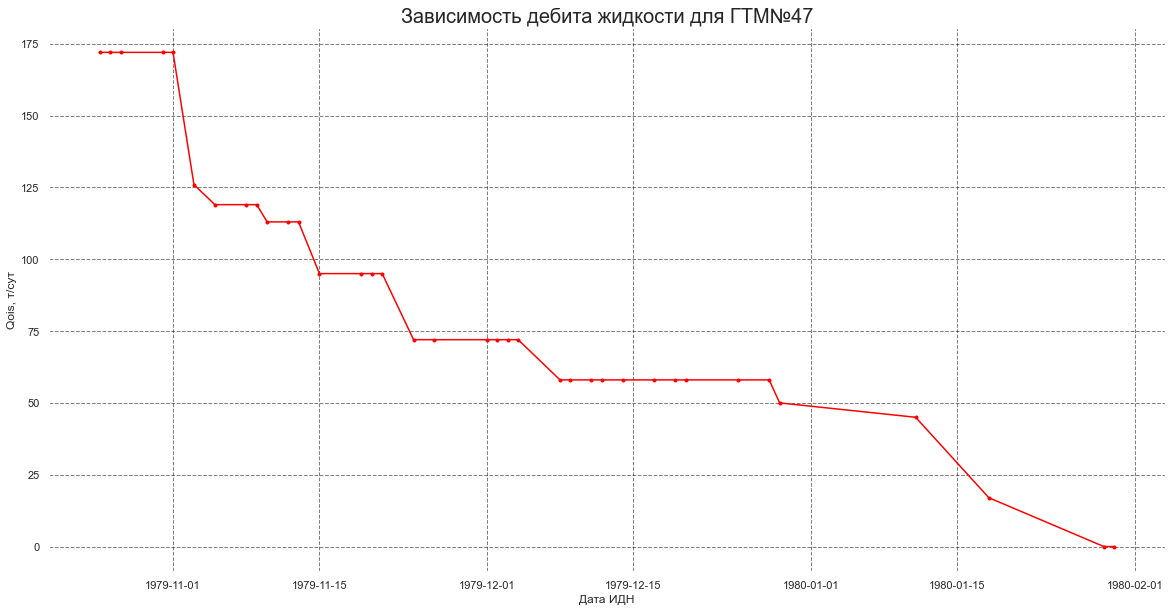

In [155]:
fig, ax = plt.subplots(figsize=(20, 10), facecolor=(1, 1, 1))
ax.set_ylabel("Qois, т/сут")
ax.set_xlabel('Дата ИДН')
ax.set_title('Зависимость дебита жидкости для ГТМ№47', fontsize = 20)
ax.set_facecolor("white")
ax.grid(color='black',linestyle = "dashed",alpha = 0.5)

xmin = id_47['date'].min()
xmax = id_47['date'].max()

x = id_47['date']
y = id_47['q_ois']

p1 = ax.plot(x, y,'.-', c='red')

plt.show()

Видим, что конечными значениями для данного ГТМ являются 0, т.к. Q_ois на дату ВНР равно NAN.

In [156]:
data_test_merge['days'] = (data_test_merge['date_vnr'] - \
                            data_test_merge.groupby('id')['date'].transform( lambda x: x.min())).dt.total_seconds()/60/60/24

In [157]:
data_test_merge.index = data_test_merge['date']

In [158]:
data_y = data_test_merge

In [159]:
make_features(data_y, 7, 1)

In [160]:
missing_values_table(data_y)

Датафрейм имеет 57 колонок.
23 колонок имеют пропущенные значения.


,Missing Values,% of Total Values
gtm_type_lbl,243625,36.1
rol_mean_q_30,116850,17.3
rol_mean_bhp_30,112955,16.7
rol_mean_inj_3_30,112955,16.7
rol_mean_inj_2_30,112955,16.7
rol_mean_inj_1_30,112955,16.7
rol_mean_inj_0_30,112955,16.7
rol_mean_wc_30,112955,16.7
lag_7,27265,4.0
rol_mean_q_7,27265,4.0


In [161]:
data_y.query('id==6')[['id','q_ois','rol_mean_q_7','rol_mean_q_30']]

,id,q_ois,rol_mean_q_7,rol_mean_q_30
date,,,,
1980-10-22,6,297.0,NaN,NaN
1980-10-23,6,297.0,NaN,NaN
1980-10-24,6,297.0,NaN,NaN
1980-10-25,6,297.0,NaN,NaN
1980-10-26,6,297.0,NaN,NaN
...,...,...,...,...
1981-04-18,6,0.0,0.0,206.066667
1981-04-19,6,0.0,0.0,196.700000
1981-04-20,6,0.0,0.0,187.333333


In [162]:
data_test = data_y.drop(['gtm_type_lbl','q_ois'], axis = 1)

In [163]:
data_test = data_test.fillna(method='ffill')

In [164]:
data_test.query('id==6')[['id','rol_mean_q_7','rol_mean_q_30']]

,id,rol_mean_q_7,rol_mean_q_30
date,,,
1980-10-22,6,NaN,NaN
1980-10-23,6,NaN,NaN
1980-10-24,6,NaN,NaN
1980-10-25,6,NaN,NaN
1980-10-26,6,NaN,NaN
...,...,...,...
1981-04-18,6,0.0,206.066667
1981-04-19,6,0.0,196.700000
1981-04-20,6,0.0,187.333333


In [165]:
missing_values_table(data_test)

Датафрейм имеет 55 колонок.
21 колонок имеют пропущенные значения.


,Missing Values,% of Total Values
rol_mean_bhp_30,29,0.0
rol_mean_inj_3_30,29,0.0
rol_mean_inj_2_30,29,0.0
rol_mean_inj_1_30,29,0.0
rol_mean_inj_0_30,29,0.0
rol_mean_wc_30,29,0.0
rol_mean_q_30,29,0.0
lag_7,7,0.0
rol_mean_inj_2_7,6,0.0
rol_mean_bhp_7,6,0.0


In [166]:
data_test = data_test.fillna(method='bfill')

In [167]:
missing_values_table(data_test)

Датафрейм имеет 55 колонок.
0 колонок имеют пропущенные значения.


,Missing Values,% of Total Values


In [168]:
data_test['q_ois'] = data_y['q_ois']

In [169]:
missing_values_table(data_test)

Датафрейм имеет 56 колонок.
1 колонок имеют пропущенные значения.


,Missing Values,% of Total Values
q_ois,3895,0.6


In [170]:
data_test = data_test[data_test['vnr'] == 1].reset_index(drop=True)

In [171]:
data_test['id']

0           6
1           8
2          22
3          23
4          24
        ...  
3890    59941
3891    59947
3892    59952
3893    60052
3894    60111
Name: id, Length: 3895, dtype: int64

In [172]:
data_test = data_test.drop(['state','vnr','well_id','id',\
                             'date','start_date','date_vnr'], axis = 1)\
# .reset_index(drop=True)

In [173]:
data_test

,d_nytr,h_din,nom_napor,water_cut,nom_podacha,p_plst,extend_hvd,pl_neft,vyazk_neft,p_nas,...,rol_mean_wc_30,rol_mean_inj_0_30,rol_mean_inj_1_30,rol_mean_inj_2_30,rol_mean_inj_3_30,rol_mean_bhp_30,nom_napor_mean,nom_podacha_mean,nom_p_plst_mean,q_ois
0,130.6,0.0,2272.0,91.0,400.0,115.0,4.000000,0.876,2.91,94.0,...,58.166667,32.693498,43.177778,54.370179,24.977491,32.055667,2272.000000,400.0,115.071038,NaN
1,222.9,0.0,1710.0,94.0,1167.0,136.0,533.481818,0.876,2.91,94.0,...,44.166667,66.381505,44.371183,81.053333,51.152975,37.060667,1710.000000,1167.0,136.000000,NaN
2,159.6,2100.0,2660.0,42.0,80.0,295.0,680.741500,0.856,1.83,115.7,...,30.200000,56.271828,108.266667,19.240860,67.482151,51.588971,2660.000000,80.0,295.000000,NaN
3,159.6,2423.0,2793.0,35.0,80.0,295.0,680.741500,0.856,1.83,115.7,...,26.833333,60.798602,93.458602,13.489677,47.476882,65.488516,2792.281081,80.0,295.000000,NaN
4,159.6,1700.0,2311.0,15.0,250.0,295.0,467.880250,0.856,1.83,115.7,...,15.366667,27.596774,62.061290,108.796774,0.000000,74.192683,2311.000000,250.0,295.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3890,129.0,1573.0,2387.0,53.0,80.0,167.0,306.668500,0.849,1.10,130.0,...,44.800000,204.754731,139.540108,208.626237,224.149462,55.756500,2387.000000,80.0,158.666667,NaN
3891,129.0,0.0,2086.0,34.0,70.0,204.0,117.156000,0.849,1.10,130.0,...,21.933333,703.676343,109.930215,183.074194,227.080645,30.716333,2086.000000,70.0,196.038043,NaN
3892,130.6,1918.0,1945.0,46.0,80.0,148.0,646.936000,0.849,1.10,130.0,...,20.200000,332.923728,288.642026,49.949498,110.288000,37.430501,1945.000000,80.0,144.755435,NaN
3893,129.0,2637.0,2337.0,64.0,45.0,180.0,658.420000,0.849,1.10,130.0,...,47.733333,17.723077,220.461176,274.707692,214.725591,51.391551,2337.000000,45.0,177.500000,NaN


### Отделение целевого признака

In [174]:
x_train = data_train.drop(['q_ois'], axis = 1)
y_train = data_train['q_ois']

In [175]:
x_test = data_test.drop(['q_ois'], axis = 1)
y_test = data_test['q_ois']

In [176]:
x_train

,d_nytr,h_din,nom_napor,water_cut,nom_podacha,p_plst,extend_hvd,pl_neft,vyazk_neft,p_nas,...,rol_mean_q_30,rol_mean_wc_30,rol_mean_inj_0_30,rol_mean_inj_1_30,rol_mean_inj_2_30,rol_mean_inj_3_30,rol_mean_bhp_30,nom_napor_mean,nom_podacha_mean,nom_p_plst_mean
0,130.6,0.0,1680.0,71.0,464.0,154.0,4.60000,0.876,2.91,94.0,...,404.300000,79.766667,0.000000,0.000000,0.000000,0.000000,49.055667,1680.000000,464.000000,156.081871
1,222.9,0.0,1710.0,80.0,1167.0,168.0,533.44000,0.876,2.91,94.0,...,1035.366667,74.333333,0.000000,0.000000,0.000000,0.000000,85.755333,1710.000000,1167.000000,168.502825
2,222.8,2084.0,1710.0,92.0,1167.0,166.0,649.30000,0.876,2.91,94.0,...,1015.333333,86.233333,142.012401,0.000000,0.000000,0.000000,89.619000,1710.000000,1167.000000,167.141975
3,223.0,1596.0,1710.0,82.0,1167.0,213.0,513.20000,0.873,2.91,98.6,...,1320.666667,76.533333,116.580000,0.000000,0.000000,0.000000,103.991333,1710.000000,1167.000000,212.666667
4,223.0,1780.0,1710.0,92.0,1167.0,192.0,513.20000,0.876,2.91,94.0,...,1264.266667,91.466667,0.000000,0.000000,0.000000,0.000000,85.987000,1710.000000,1167.000000,193.363636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11275,132.0,1288.0,1814.0,46.0,50.0,205.0,135.00000,0.849,0.98,130.0,...,66.233333,43.333333,0.000000,0.000000,66.616356,266.535484,94.261134,1852.294118,54.117647,205.000000
11276,127.0,0.0,2032.0,29.0,80.0,221.0,7.51000,0.849,0.98,130.0,...,40.833333,24.466667,0.000000,0.000000,91.616359,353.541897,41.944000,2032.000000,80.000000,204.177143
11277,130.6,1485.0,1352.0,90.0,60.0,229.0,309.93400,0.849,0.98,130.0,...,41.100000,90.500000,0.000000,375.909140,273.629743,0.000000,150.052649,1352.000000,60.000000,229.563218
11278,130.6,1741.0,1872.0,92.0,80.0,218.0,309.93400,0.849,0.98,130.0,...,49.933333,91.366667,0.000000,327.742366,297.981212,0.000000,80.228642,1872.000000,80.000000,218.000000


In [177]:
y_train

0         304.0
1        1118.0
2        1100.0
3        1415.0
4        1144.0
          ...  
11275     104.0
11276      47.0
11277      76.0
11278      59.0
11279      59.0
Name: q_ois, Length: 11280, dtype: float64

In [178]:
x_test

,d_nytr,h_din,nom_napor,water_cut,nom_podacha,p_plst,extend_hvd,pl_neft,vyazk_neft,p_nas,...,rol_mean_q_30,rol_mean_wc_30,rol_mean_inj_0_30,rol_mean_inj_1_30,rol_mean_inj_2_30,rol_mean_inj_3_30,rol_mean_bhp_30,nom_napor_mean,nom_podacha_mean,nom_p_plst_mean
0,130.6,0.0,2272.0,91.0,400.0,115.0,4.000000,0.876,2.91,94.0,...,177.966667,58.166667,32.693498,43.177778,54.370179,24.977491,32.055667,2272.000000,400.0,115.071038
1,222.9,0.0,1710.0,94.0,1167.0,136.0,533.481818,0.876,2.91,94.0,...,300.733333,44.166667,66.381505,44.371183,81.053333,51.152975,37.060667,1710.000000,1167.0,136.000000
2,159.6,2100.0,2660.0,42.0,80.0,295.0,680.741500,0.856,1.83,115.7,...,42.300000,30.200000,56.271828,108.266667,19.240860,67.482151,51.588971,2660.000000,80.0,295.000000
3,159.6,2423.0,2793.0,35.0,80.0,295.0,680.741500,0.856,1.83,115.7,...,39.866667,26.833333,60.798602,93.458602,13.489677,47.476882,65.488516,2792.281081,80.0,295.000000
4,159.6,1700.0,2311.0,15.0,250.0,295.0,467.880250,0.856,1.83,115.7,...,79.066667,15.366667,27.596774,62.061290,108.796774,0.000000,74.192683,2311.000000,250.0,295.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3890,129.0,1573.0,2387.0,53.0,80.0,167.0,306.668500,0.849,1.10,130.0,...,26.533333,44.800000,204.754731,139.540108,208.626237,224.149462,55.756500,2387.000000,80.0,158.666667
3891,129.0,0.0,2086.0,34.0,70.0,204.0,117.156000,0.849,1.10,130.0,...,27.266667,21.933333,703.676343,109.930215,183.074194,227.080645,30.716333,2086.000000,70.0,196.038043
3892,130.6,1918.0,1945.0,46.0,80.0,148.0,646.936000,0.849,1.10,130.0,...,11.366667,20.200000,332.923728,288.642026,49.949498,110.288000,37.430501,1945.000000,80.0,144.755435
3893,129.0,2637.0,2337.0,64.0,45.0,180.0,658.420000,0.849,1.10,130.0,...,41.333333,47.733333,17.723077,220.461176,274.707692,214.725591,51.391551,2337.000000,45.0,177.500000


In [179]:
y_test

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
3890   NaN
3891   NaN
3892   NaN
3893   NaN
3894   NaN
Name: q_ois, Length: 3895, dtype: float64

In [180]:
len(x_test)/(len(x_test)+len(x_train))

0.25667215815485994

Тестовая выборка составляет 20% от общей выборки, что является соответствует нормам разделения (80/20).

In [181]:
missing_values_table(x_test)

Датафрейм имеет 48 колонок.
0 колонок имеют пропущенные значения.


,Missing Values,% of Total Values


In [182]:
missing_values_table(x_train)

Датафрейм имеет 48 колонок.
0 колонок имеют пропущенные значения.


,Missing Values,% of Total Values


In [183]:
x_test.columns

Index(['d_nytr', 'h_din', 'nom_napor', 'water_cut', 'nom_podacha', 'p_plst',
       'extend_hvd', 'pl_neft', 'vyazk_neft', 'p_nas', 'inject_0', 'inject_1',
       'inject_2', 'inject_3', 'bhp', 'formation_lbl', 'state_age',
       'state_0_count', 'vnr_count', 'days', 'year', 'month', 'day',
       'dayofweek', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6',
       'lag_7', 'rol_mean_q_7', 'rol_mean_wc_7', 'rol_mean_inj_0_7',
       'rol_mean_inj_1_7', 'rol_mean_inj_2_7', 'rol_mean_inj_3_7',
       'rol_mean_bhp_7', 'rol_mean_q_30', 'rol_mean_wc_30',
       'rol_mean_inj_0_30', 'rol_mean_inj_1_30', 'rol_mean_inj_2_30',
       'rol_mean_inj_3_30', 'rol_mean_bhp_30', 'nom_napor_mean',
       'nom_podacha_mean', 'nom_p_plst_mean'],
      dtype='object')

In [184]:
cat = x_train.select_dtypes(include='object').columns.to_list()

In [185]:
numeric = x_train.select_dtypes(exclude='object').columns.to_list()

In [186]:
col_transformer = ColumnTransformer(
        [("ordinal", OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1), cat),
        ("scaler", StandardScaler(), numeric)],
        remainder='passthrough'
        )
col_transformer.fit(x_train)

print("******************** Training data ********************")
# display(x_train.head())
features_train_enc = pd.DataFrame(col_transformer.transform(x_train), columns=x_train.columns, index=x_train.index)
display(features_train_enc.head())

print()
print("******************** Test data ********************")
# display(x_test.head())
features_test_enc = pd.DataFrame(col_transformer.transform(x_test), columns=x_test.columns, index=x_test.index)
display(features_test_enc.head())

******************** Training data ********************


,d_nytr,h_din,nom_napor,water_cut,nom_podacha,p_plst,extend_hvd,pl_neft,vyazk_neft,p_nas,...,rol_mean_q_30,rol_mean_wc_30,rol_mean_inj_0_30,rol_mean_inj_1_30,rol_mean_inj_2_30,rol_mean_inj_3_30,rol_mean_bhp_30,nom_napor_mean,nom_podacha_mean,nom_p_plst_mean
0,30.0,-0.083924,-0.792411,-1.362101,0.232163,1.693034,-2.061311,-1.219508,0.875774,0.636904,...,1.795957,0.546247,-0.929221,-0.920828,-0.94223,-0.922271,-1.137237,-1.365736,1.698306,-2.056136
1,30.0,10.961502,-0.792411,-1.264424,0.497004,6.167786,-1.690214,2.004004,0.875774,0.636904,...,6.355407,0.384360,-0.929221,-0.920828,-0.94223,-0.922271,-0.036323,-1.267136,6.206976,-1.723078
2,30.0,10.949536,1.232074,-1.264424,0.850125,6.167786,-1.743228,2.710222,0.875774,0.636904,...,6.210667,0.738921,-0.390213,-0.920828,-0.94223,-0.922271,0.079579,-1.267136,6.206976,-1.759568
3,30.0,10.973469,0.758010,-1.264424,0.555858,6.167786,-0.497403,1.880633,0.603567,0.636904,...,8.416697,0.449909,-0.486742,-0.920828,-0.94223,-0.922271,0.510719,-1.267136,6.206976,-0.538860
4,30.0,10.973469,0.936756,-1.264424,0.850125,6.167786,-1.054048,1.880633,0.875774,0.636904,...,8.009207,0.894849,-0.929221,-0.920828,-0.94223,-0.922271,-0.029374,-1.267136,6.206976,-1.056455



******************** Test data ********************


,d_nytr,h_din,nom_napor,water_cut,nom_podacha,p_plst,extend_hvd,pl_neft,vyazk_neft,p_nas,...,rol_mean_q_30,rol_mean_wc_30,rol_mean_inj_0_30,rol_mean_inj_1_30,rol_mean_inj_2_30,rol_mean_inj_3_30,rol_mean_bhp_30,nom_napor_mean,nom_podacha_mean,nom_p_plst_mean
0,30.0,-0.083924,-0.792411,0.565384,0.820698,1.285659,-3.095081,-1.223165,0.875774,0.636904,...,0.160701,-0.097327,-0.805133,-0.757553,-0.743246,-0.829512,-1.647202,0.579977,1.287844,-3.155809
1,30.0,10.961502,-0.792411,-1.264424,0.908979,6.167786,-2.538435,2.004259,0.875774,0.636904,...,1.047689,-0.514457,-0.677270,-0.753040,-0.645591,-0.732303,-1.497062,-1.267136,6.206976,-2.594615
2,63.0,3.386470,1.247617,1.828668,-0.621213,-0.751213,1.676165,2.901872,-0.938941,-0.345685,...,-0.819489,-0.930595,-0.715642,-0.511422,-0.871813,-0.671661,-1.061243,1.855207,-0.764467,1.668843
3,63.0,3.386470,1.561393,2.261701,-0.827200,-0.751213,1.676165,2.901872,-0.938941,-0.345685,...,-0.837070,-1.030905,-0.698460,-0.567418,-0.892861,-0.745955,-0.644286,2.289972,-0.764467,1.668843
4,63.0,3.386470,0.859040,0.692364,-1.415735,0.330875,1.676165,1.604389,-0.938941,-0.345685,...,-0.553850,-1.372555,-0.824478,-0.686146,-0.544056,-0.922271,-0.383179,0.708157,0.325823,1.668843


## Базовая модель

[Описание](#x)

[Содержание](#intro)

Для построения базовой линии используем константную модель среднего, с которой потом сравним полученные метрики. Данный шаг необходим для оценки адекватности модели.

In [187]:
predictions = pd.Series(y_train.mean(), index=x_train.index)
mape_based = mean_absolute_percentage_error(y_train,predictions)
mape_based

1.4389841933002794

## Обучение моделей

[Описание](#x)

[Содержание](#intro)

Создадим формулу построения модели регрессии с поиском наилучших гиперпараметров по сетке.

In [188]:
def fit_model(estimator, param_grid, X_train, y_train):
    """Ищет гиперпараметры модели на кросс-валидации. 
    Выводит лучшую метрику и параметры лучшей модели, а также возвращает лучшую модель, обученную на всей выборке.    
    """
    model = GridSearchCV(estimator=estimator, 
                            param_grid=param_grid, 
                            n_jobs=-1, 
                            cv=4,
                            scoring='neg_mean_absolute_percentage_error')

    model.fit(X_train, y_train)

    best_index = model.best_index_
    best_mape = round(model.cv_results_['mean_test_score'][best_index], 2)

    print(f"Best MAPE = {-best_mape:.2f}")
    print(f"Best params: {model.best_params_}")

    return model.best_estimator_
    return model.best_score_

### Линейная регрессия

In [189]:
lr = LinearRegression()
lr.fit(features_train_enc, y_train)
scores_lr = cross_val_score (lr,features_train_enc,y_train,cv=5, scoring = 'neg_mean_absolute_percentage_error',error_score='raise') 
final_score_lr = scores_lr.mean()*(-1)

In [190]:
final_score_lr

0.2572445216859133

### RandomForestRegressor

In [191]:
RANDOM_STATE = 18082023

In [192]:
%%time

rf_estimator = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1)

rf_param_grid =  {
    'n_estimators': range(20, 100, 10),
    'max_depth': range(4, 21, 2),
}

rf_best_model = fit_model(
    estimator=rf_estimator,
    param_grid=rf_param_grid,
    X_train=features_train_enc,
    y_train=y_train
)

Best MAPE = 0.16
Best params: {'max_depth': 16, 'n_estimators': 90}
CPU times: total: 51.9 s
Wall time: 8min 27s


In [193]:
rf_best_model = GridSearchCV(estimator=rf_estimator, 
                            param_grid={'max_depth': [16], 'n_estimators': [90]}, 
                            n_jobs=-1, 
                            cv=4,
                            scoring='neg_mean_absolute_percentage_error')
rf_best_model = rf_best_model.fit(features_train_enc,y_train)

### LGBMRegressor

In [194]:
%%time
lgbm_estimator = LGBMRegressor(random_state=RANDOM_STATE, n_jobs=-1)

lgbm_param_grid = {
    "n_estimators": range(150, 201, 10), 
    "max_depth": range(2, 13, 2),
    'learning_rate': [0.03, 0.05, 0.1],
}

LGBMRegressor = fit_model(
    estimator=lgbm_estimator,
    param_grid=lgbm_param_grid,
    X_train=features_train_enc,
    y_train=y_train
)

Best MAPE = 0.16
Best params: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200}
CPU times: total: 8.47 s
Wall time: 1min 55s


In [195]:
LGBMRegressor = GridSearchCV(estimator=lgbm_estimator, 
                            param_grid={'learning_rate': [0.1], 'max_depth': [12], 'n_estimators': [160]}, 
                            n_jobs=-1, 
                            cv=4,
                            scoring='neg_mean_absolute_percentage_error')
LGBMRegressor = LGBMRegressor.fit(features_train_enc,y_train)

### XGBRegressor

In [196]:
%%time
xgb_estimator = XGBRegressor(random_state=RANDOM_STATE, n_jobs=-1)

xgb_param_grid = {
    "n_estimators": range(160, 211, 10), 
    "max_depth": range(2, 11, 1),
    'learning_rate': [0.01, 0.05, 0.1]
}

xgb_best_model = fit_model(
    estimator=xgb_estimator,
    param_grid=xgb_param_grid,
    X_train=features_train_enc,
    y_train=y_train
)

Best MAPE = 0.15
Best params: {'learning_rate': 0.05, 'max_depth': 9, 'n_estimators': 200}
CPU times: total: 1min 3s
Wall time: 32min 52s


In [197]:
xgb_best_model = GridSearchCV(estimator=xgb_estimator, 
                            param_grid={'learning_rate': [0.05], 'max_depth': [9], 'n_estimators': [200]}, 
                            n_jobs=-1, 
                            cv=4,
                            scoring='neg_mean_absolute_percentage_error')
xgb_best_model = xgb_best_model.fit(features_train_enc,y_train)

### CatBoostRegressor

In [198]:
%%time
catboost_estimator = CatBoostRegressor(random_state=RANDOM_STATE, verbose=False)

catboost_param_grid = {
    "iterations": range(100, 146, 15),
    "learning_rate": [0.1, 0.15, 0.2],
    "depth": range(2, 9, 2)
}

catboost_best_model = fit_model(
    estimator=catboost_estimator,
    param_grid=catboost_param_grid,
    X_train=features_train_enc,
    y_train=y_train
)### CatBoostRegressor

Best MAPE = 0.16
Best params: {'depth': 6, 'iterations': 145, 'learning_rate': 0.15}
CPU times: total: 11.5 s
Wall time: 3min 9s


In [199]:
catboost_best_model = GridSearchCV(estimator=catboost_estimator, 
                            param_grid={'depth': [6], 'iterations': [145], 'learning_rate': [0.15]}, 
                            n_jobs=-1, 
                            cv=4,
                            scoring='neg_mean_absolute_percentage_error')
catboost_best_model = catboost_best_model.fit(features_train_enc,y_train)

## Анализ полученных результатов

[Описание](#x)

[Содержание](#intro)

In [201]:
res = pd.DataFrame({final_score_lr, -rf_best_model.best_score_, -LGBMRegressor.best_score_, -xgb_best_model.best_score_,
                    -catboost_best_model.best_score_},
                         index = ['LR','XGB','LGBM','RFR','CatBoost'],\
                        columns = ['MAPE'])

res

,MAPE
LR,0.257245
XGB,0.151547
LGBM,0.163832
RFR,0.159099
CatBoost,0.159767


In [202]:
sample

,id,Q_OIS
0,6,0
1,8,0
2,22,0
3,23,0
4,24,0
...,...,...
3890,59941,0
3891,59947,0
3892,59952,0
3893,60052,0


In [203]:
xgbm_test_pred = xgb_best_model.predict(features_test_enc)

In [204]:
xgbm_test_pred

array([187.33536 , 271.54187 ,  43.723423, ...,  16.546782,  46.055336,
        26.444145], dtype=float32)

In [205]:
analysis = pd.DataFrame(data = xgbm_test_pred,\
                        index = sample.index,\
                        columns = ['Q_OIS'])

In [206]:
analysis['id'] = sample['id']

In [207]:
analysis = analysis[['id','Q_OIS']]

In [208]:
analysis

,id,Q_OIS
0,6,187.335358
1,8,271.541870
2,22,43.723423
3,23,44.141010
4,24,90.695992
...,...,...
3890,59941,47.535728
3891,59947,28.908224
3892,59952,16.546782
3893,60052,46.055336


In [209]:
analysis.to_csv(r'C:/Users/aygul/OneDrive/Документы/Башнипи/sample_analysis.csv',\
                sep=';', index=False,header=True,encoding='utf-8')

## Анализ важности признаков

[Описание](#x)

[Содержание](#intro)

In [210]:
xgb_best_model.best_estimator_.feature_importances_

array([6.9459470e-04, 3.2985476e-03, 1.3554150e-03, 1.4160695e-03,
       5.8670365e-03, 7.4912468e-03, 1.8940519e-03, 1.2440372e-03,
       1.8138196e-03, 2.4063224e-03, 2.0254967e-03, 8.6857058e-04,
       1.1598807e-03, 1.1239193e-03, 1.3093214e-03, 4.1268687e-03,
       1.9608922e-03, 1.7571484e-03, 1.5657642e-03, 1.1644702e-03,
       6.7471331e-03, 1.1429315e-03, 1.4885407e-03, 1.3009508e-03,
       1.7128991e-03, 2.1486979e-03, 7.6265596e-03, 1.9421874e-02,
       2.1460090e-02, 2.3011347e-02, 3.7013154e-02, 3.3973858e-02,
       6.1331233e-03, 1.2026358e-03, 1.4322542e-03, 1.3063609e-03,
       1.1973364e-03, 2.5613946e-03, 7.5103641e-01, 4.9125664e-03,
       1.3530699e-03, 1.5381802e-03, 1.2447709e-03, 1.3598135e-03,
       1.2539460e-02, 1.9955756e-03, 6.2080547e-03, 2.3875262e-03],
      dtype=float32)

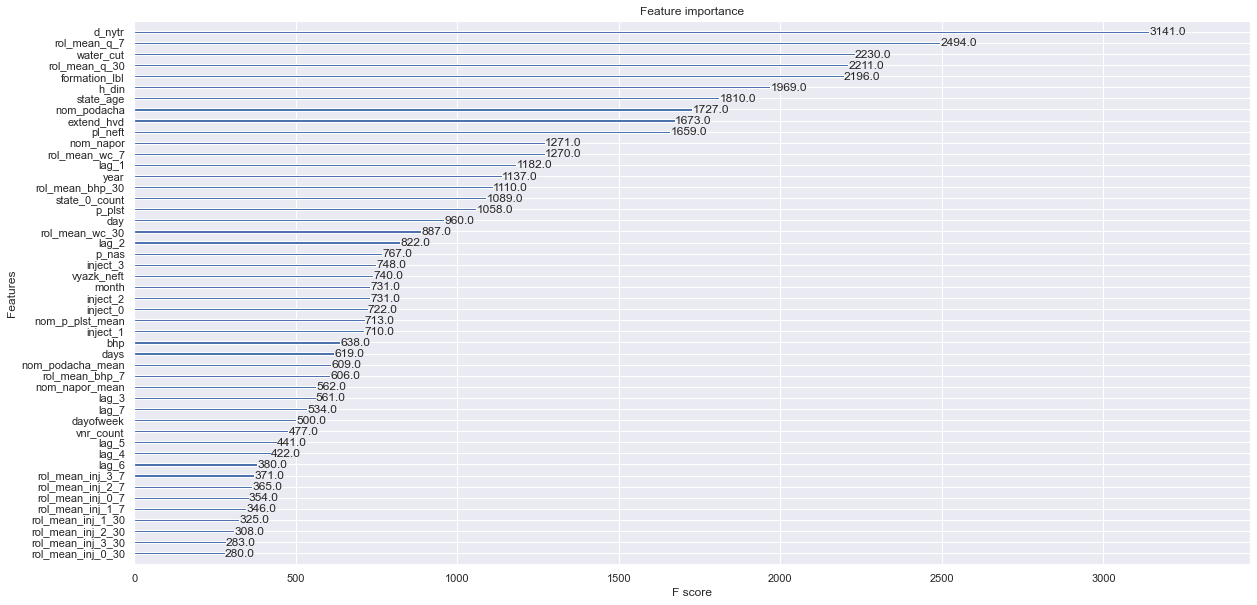

In [211]:
fig, ax = plt.subplots(figsize=(20, 10), facecolor=(1, 1, 1))
plot_importance(xgb_best_model.best_estimator_.get_booster(), ax=ax)
plt.show()

Самыми важными признаками оказались проницаемость, скользящее среднее дебита скважины за 7 дней, обводненность.

## Вывод

[Описание](#x)

[Содержание](#intro)

Мы выполнили построение модели прогноза дебита жидкости на дату ВНР. Основными этапами работы были:
- предобработка данных тренировочного датафрейма,
- обработка пропусков тренировочного датафрейма с заменой на ближайшие непропущенные значения
- удаление аномальных значений
- генерация новых признаков, связанных с обработкой временного ряда
- удаление коррелирующих признаков
- все те же самые этапы для тестового датафрейма
- построение константной модели для проверки адекватности нашей модели
- построение модели для нескольких алгоритмов

На полученных признаках были обучены несколько моделей, среди которых лучшее качество показала модель XGBRegressor с параметрами: learning_rate = 0.05, max_depth = 9, n_estimators = 200. При валидации эта модель показала MAPE = 0.15.